# 목차

- Node 10 학습 및 실습
  - Colab 기준 경로로 작성
  - 2. 자율주행 보조장치
    - 2-1. KITTI 데이터셋
    - 2-2. 데이터 살펴보기
  - 3. RetinaNet
    - 3-1. Focal Loss
    - 3-2. FPN(Feature Pyramid Network)
  - 4. 데이터 준비
    - 4-1. 데이터 파이프 라인
    - 4-2. Encoding
  - 5. Model 작성
  - 6. Model 학습
  - 7. 모델 성능 시각화
  - 8. 결과 확인하기
- 프로젝트 : 자율주행 보조 시스템 만들기



# 간단 회고

---

기존 Node 과정에서 
- x와 y좌표 위치 교체
- 무작위로 수평 뒤집기(Flip)
- 이미지 크기 조정 및 패딩 추가
- 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정

추가로 ColorJitter 추가
- 아무래도 데이터를 살펴보니 다양한 환경, 즉 건물 그림자에 의해 어두워지거나 다른 사진에 비해 어둡다거나 등등이 존재
- 그래서 이것만 추가함

---

Anchor Box의 aspect ratio 설정
- default로 [0.5, 1.0, 2.0]로 되어 있었음. 다만 객체의 크기는 다양할 수 있고, 본 데이터에 맞게끔 조정하고 싶었음
- 학습 데이터의 모든 박스의 가로/세로 비율을 K-means로 데이터의 비율을 찾아봄
- 결과 : [0.530, 1.367, 2.438] 인데.. 차이가 있는지는 잘 모르겠음 (둘을 비교하며 모델을 돌리진 못함)

--- 
build_head 함수
- kernel_init라는 변수로 weight initialization를 했지만 막상 적용이 안되어있었음
    - 적용이 안되었기에, Conv는 균등분포로 초기화가 된다고 하는 듯 함
- 다시 적용시켜서 정규분포(0,0.01)로 초기화
- 적용 안된채로 돌리다가 도중에 멈추고, 다시 초기화하고 진행함
    - 초기화 방식도 학습에 영향을 주기에, 달라질거라고 생각이 듬
    - epoch를 몇 안돌렸기에, 둘의 차이는 잘 모르겠음(초기 수치는 거의 동일)
    - 아무래도 backbone 자체는 ResNet이고, head부분만 이 초기화를 따르기에 그렇게 영향이 안되는 건가 싶음

---

Metric 추가 - mAP(mean Average Precision)
- Detection 성능을 평가하는 대표 지표
- Precision-Recall 곡선 면적(AP)을 클래스별로 계산한 뒤 평균낸 값
- 값 0.01 → 1% 성능 수준

mAP@50(AP50)
- IoU 기준을 0.50으로 고정하여 산출한 mAP
- IoU ≥ 0.5일 때만 TP로 인정하는 가장 기본적인 AP 지표

---

Loss와 mAP 시각화
- Loss는 꾸준히 하락 중
    - 구간을 나눠서 보기에는 특별한게 없음 (epoch를 더 돌리거나 학습률을 변경했어야 했을거임)
    - 다만 학습률과 optimizer를 몇번 바꿔보며 3~5 epoch 시도해봤을때, 초기 epoch의 수치는 거의 유사했음
    - 학습률을 더 극단적으로 바꿨어야하나 싶음
- mAP도 낮은 수치지만 꾸준히 상승 추세로 보임
    - 6 epoch를 기점으로 증감을 반복하며 진행이 됨 
- 수렴 하지 못함, 아무래도 여기서 epoch를 두배 이상은 돌려야할 것으로 보임
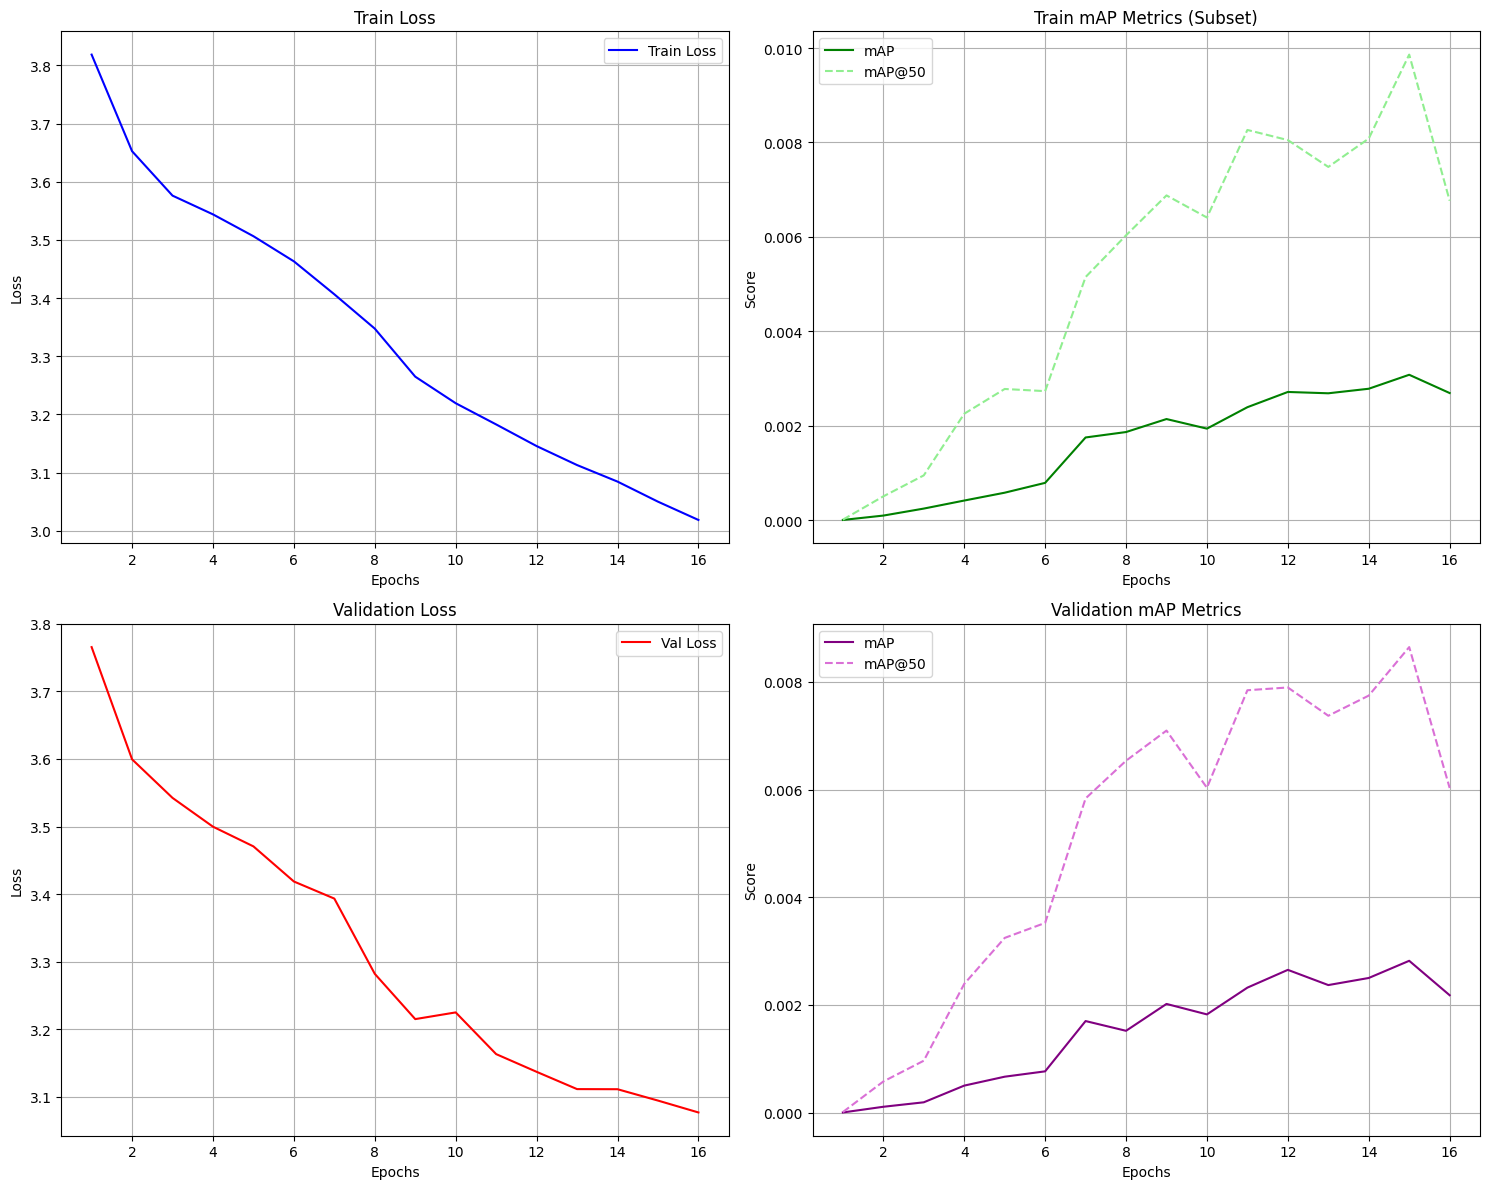

---

수렴하지 못하였고, mAP가 굉장히 낮은 수치를 보이기에, 학습 이후 프로젝트 코드를 진행했지만 detected된 bbox가 없어서 무의미함
- 다시금 Threshold를 낮추고 진행 0.5 -> 0.15로 하게 되면 아래 이미지처럼 진행
- 다만 수렴 되지 않았기에, 아무곳에나 bbox가 있는 듯 함
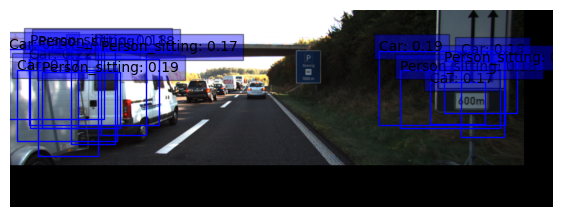

# 추가 LMS 학습 후 진행
---
- 아직도 뚜렷하게 Loss는 하락중, mAP는 증가 중
- 16epoch 이후에는 batch_size를 줄이고, LMS에서 진행해서 그런지 mAP는 가파른 기울기를 보이며 상승중
- 그럼에도 아직 많이 부족해 보임
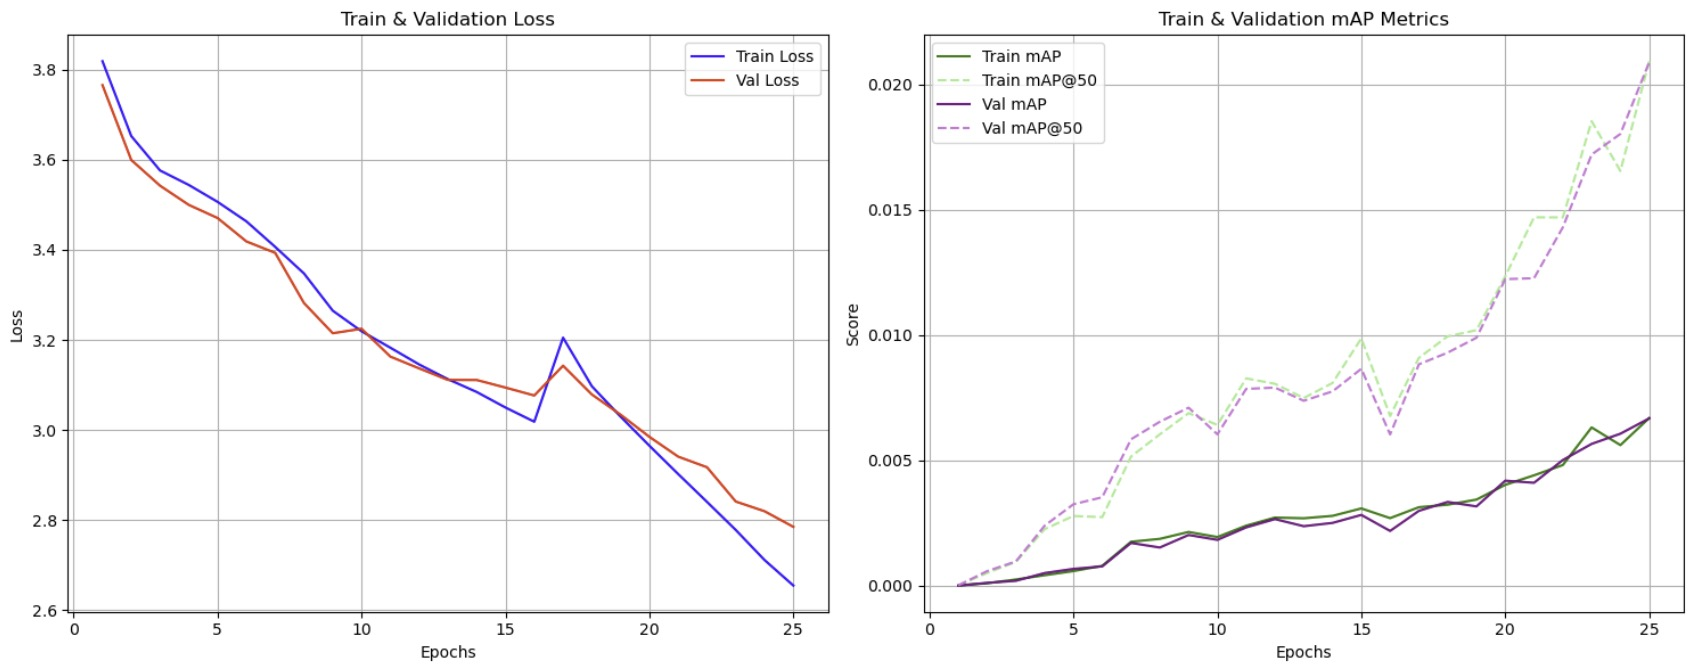

---
- 검출에서는 확실히 신뢰도 점수가 상승 한 것이 보이지만, 여전히 수렴하지 않은 모델이라 비교가 무의미해보임
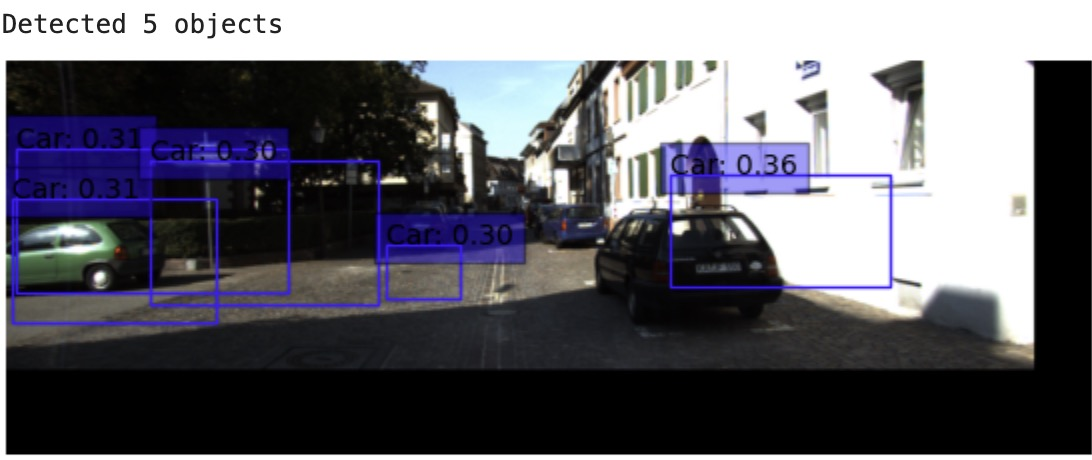

---
10장에 대해서 Go or Stop을 봐보자 (4장에 대해서 Stop을 외쳤는데, 그 중 3장을 가져와봄)
- 첫번째 사진은 차가 많이 보인다. 옆차도 커보이기에 Stop이라 외쳤을 수 있다.
- 두번째는 사람이 앞에 보인다. Stop이라 했을 수 있다.
- 세번째는 수렴되지 않은 모델이 허공에 bbox를 그려서 Stop이라 외쳤을 것이다.
    - 1,2번째 사진도 그랬을 가능성이 굉장히 높다.
- 우선 피어리뷰 이후에 추가해야겠지만, Go or Stop 에도 bbox를 그려서 더 확인해야겠다.(아침 9시 50분에 급하게 적는중...)

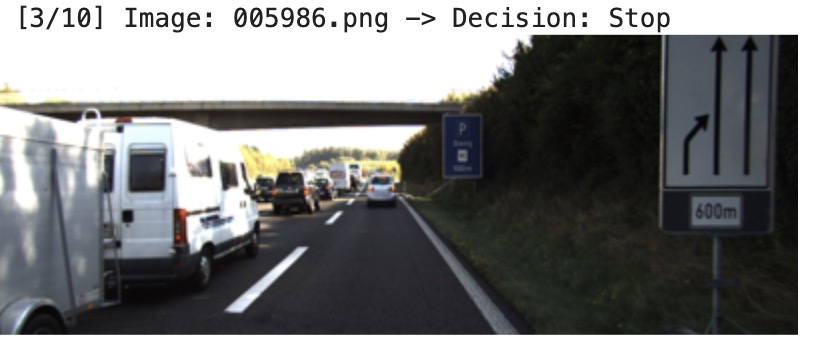
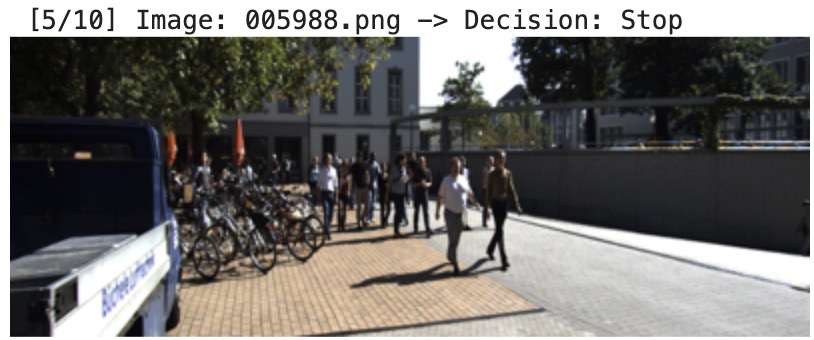
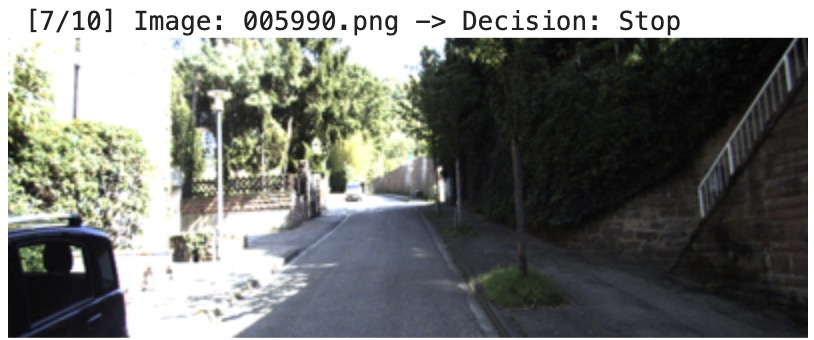


# Node 10 학습 및 실습

## Colab 기준 경로로 작성

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

## 2. 자율주행 보조장치
### 2-1. KITTI 데이터셋
- 자율주행 보조장치 object detection 요구사항

  - 사람이 카메라에 감지되면 정지
  - 차량이 일정 크기 이상으로 감지되면 정지


- [KITTI 데이터셋](https://www.cvlibs.net/datasets/kitti/)

In [2]:
import sys
print(sys.executable)

/opt/conda/bin/python


In [1]:
!pip install --upgrade "torchmetrics[detection]" pycocotools faster-coco-eval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.6/585.6 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [torchmetrics] [torchmetrics]


In [2]:
import os
import glob
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageDraw

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim.lr_scheduler import LambdaLR

import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.models as models
from torchvision.ops import nms

# mAP 계산
import torchmetrics

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from sklearn.cluster import KMeans


In [3]:
save_dir = "KITTY"
# os.makedirs(save_dir, exist_ok=True)

In [6]:
# if not os.path.exists(os.path.join(save_dir, 'data_object_image_2.zip')):
#     !wget -P {save_dir} https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip
# if not os.path.exists(os.path.join(save_dir, 'data_object_label_2.zip')):
#     !wget -P {save_dir} https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip


# # 구글 드라이브 왔다갔다할 거를 Local로 왔다갔다하게 하여 약간의 시간 빠르게 하기 위해
# local_data_dir = '/content/KITTI'
# os.makedirs(local_data_dir, exist_ok=True)

# print("Copying and unzipping data to local storage for fast training... (This may take a minute)")
# !unzip -q {save_dir}/data_object_image_2.zip -d {local_data_dir}
# !unzip -q {save_dir}/data_object_label_2.zip -d {local_data_dir}
# print("Data prepared at /content/KITTI")

### 2-2. 데이터 살펴보기

#### KITTI 데이터셋 Object Label 정보

| Values | Name        | Description |
|--------|------------|-------------|
| 1      | type       | Describes the type of object: 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc' or 'DontCare' |
| 1      | truncated  | Float from 0 (non-truncated) to 1 (truncated), where truncated refers to the object leaving image boundaries |
| 1      | occluded   | Integer (0,1,2,3) indicating occlusion state:<br>0 = fully visible, 1 = partly occluded, 2 = largely occluded, 3 = unknown |
| 1      | alpha      | Observation angle of object, ranging [-π .. π] |
| 4      | bbox       | 2D bounding box of object in the image (0-based index): contains left, top, right, bottom pixel coordinates |
| 3      | dimensions | 3D object dimensions: height, width, length (in meters) |
| 3      | location   | 3D object location x, y, z in camera coordinates (in meters) |
| 1      | rotation_y | Rotation ry around Y-axis in camera coordinates [-π .. π] |
| 1      | score      | Only for results: Float, indicating confidence in detection, needed for p/r curves, higher is better |


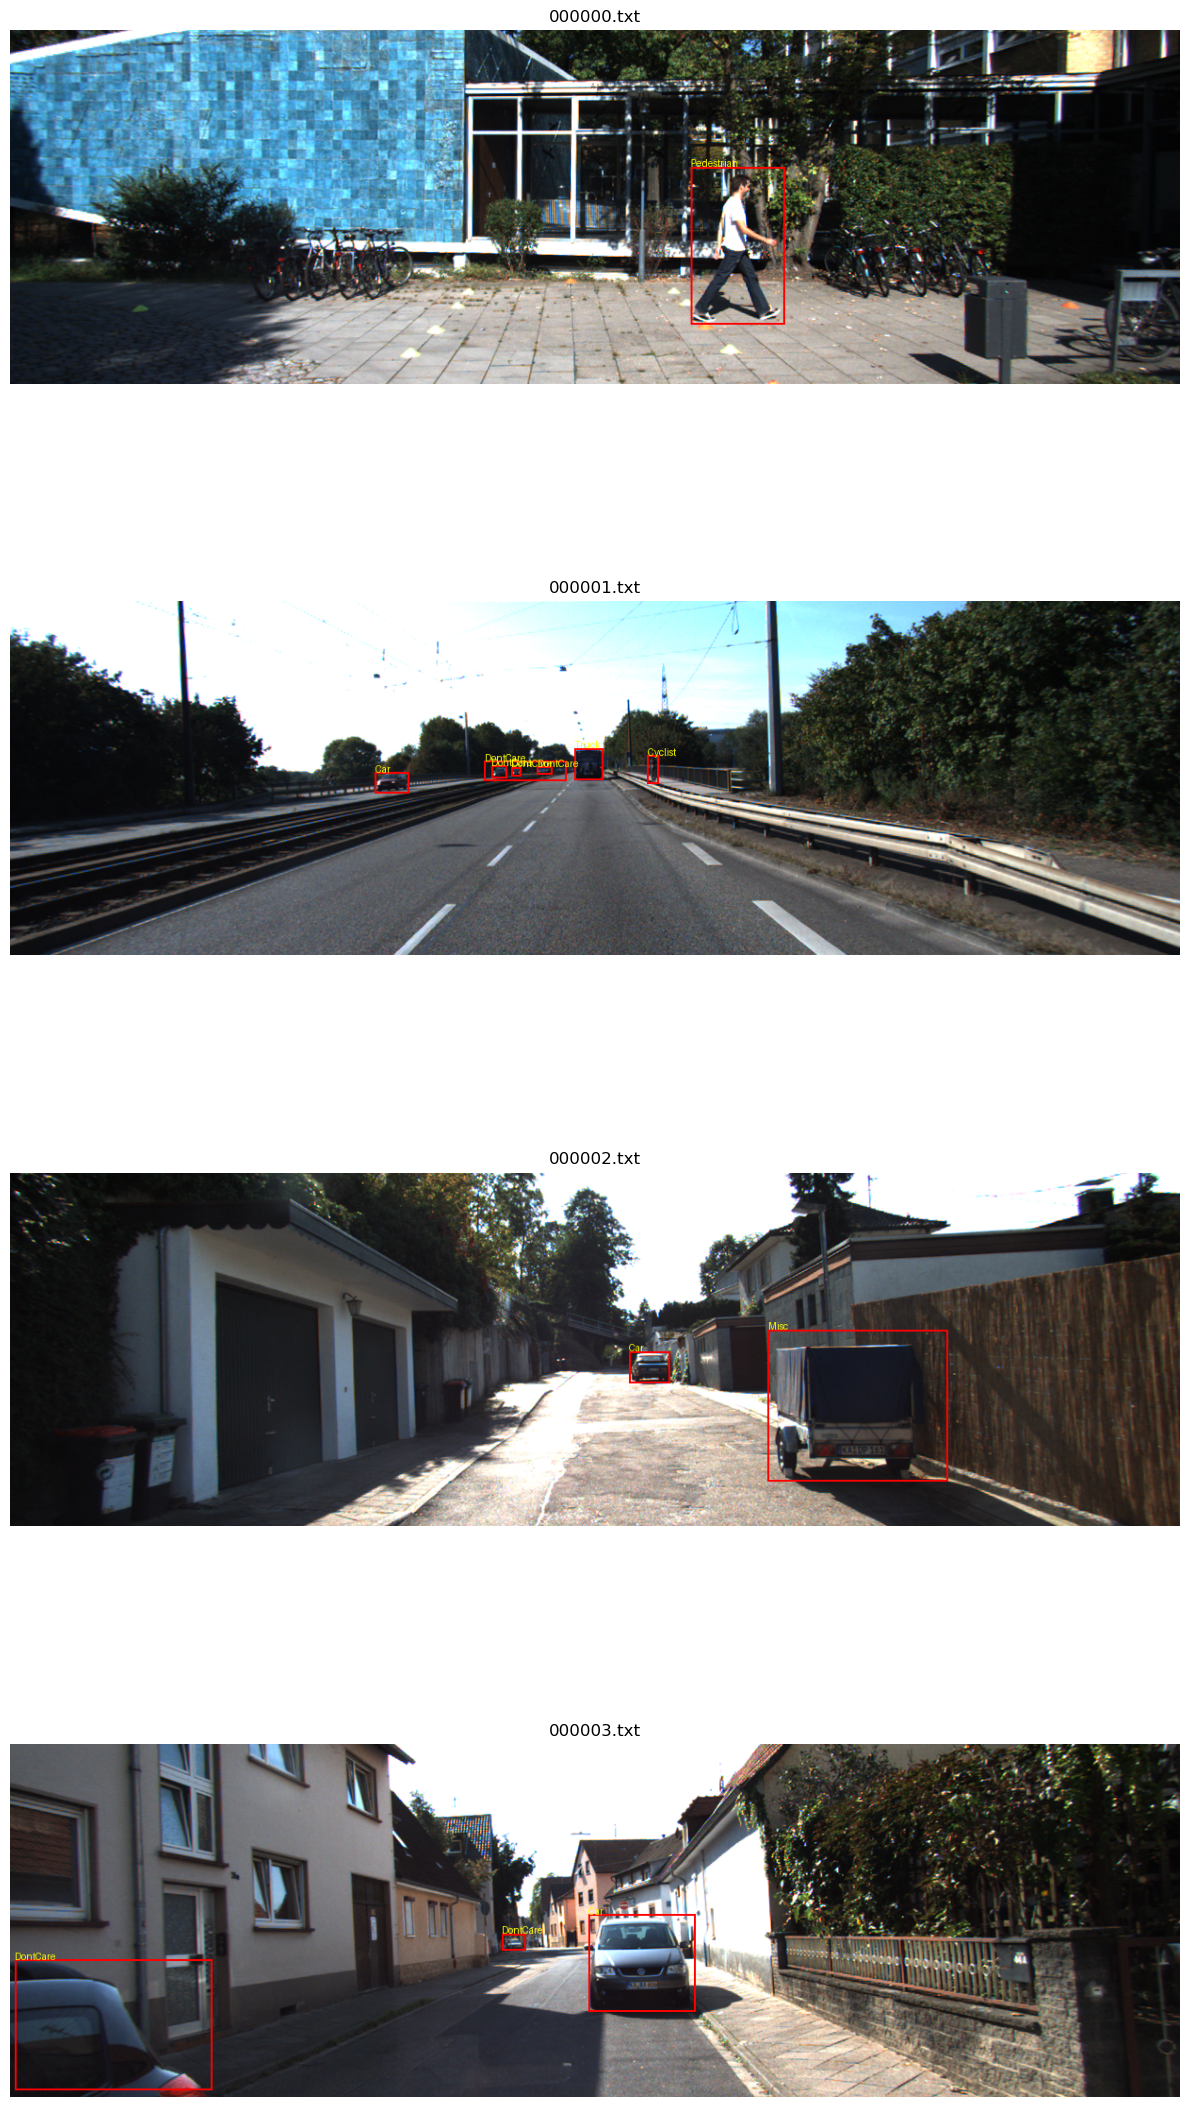

In [7]:
# 정말 현실에서 볼 수 있는 환경이 담겨져있음
# 그 중 자동차와 사람에 집중되어있음
# 가까이에 있는 객체도 있지만, 사진상으로 굉장히 멀리 있는 객체(내 눈에도 잘 안보이는 부분들)도 표시되어있음

img_dir = "KITTY/training/training/image_2"
label_dir = "KITTY/training/training/label_2"

img_files = sorted(glob.glob(os.path.join(img_dir, "*.png")))


num_images = 4
img_files = img_files[:num_images]


fig, axes = plt.subplots(num_images, 1, figsize=(12, 6*num_images))

for i, img_path in enumerate(img_files):
    img = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(img)

    base_name = os.path.basename(img_path).replace(".png", ".txt")
    label_path = os.path.join(label_dir, base_name)

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                items = line.strip().split()
                cls = items[0]
                # bbox 좌표: left, top, right, bottom
                bbox = list(map(float, items[4:8]))
                draw.rectangle(bbox, outline="red", width=2)
                draw.text((bbox[0], bbox[1]-10), cls, fill="yellow")

    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(base_name)

plt.tight_layout()
plt.show()


## 3. RetinaNet
- [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)
- RetinaNet에서는 focal loss와 FPN(Feature Pyramid Network) 를 적용한 네트워크를 사용

### 3-1. Focal Loss
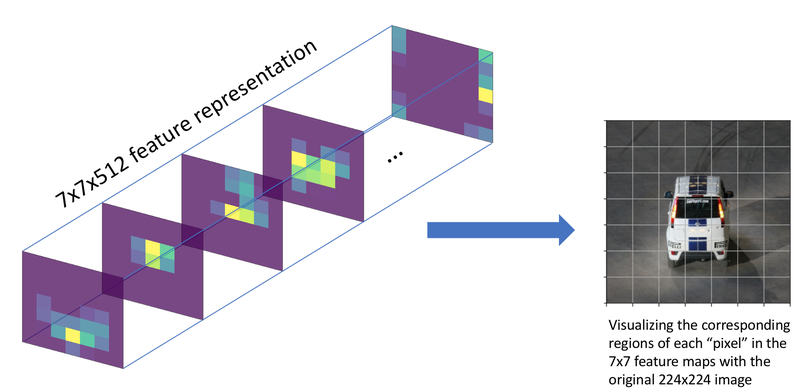

**Focal Loss 도입 배경과 목적**

1. 1-stage detection 문제
    - YOLO, SSD 같은 1-stage 모델은 이미지의 모든 **grid** 를 한 번에 학습함.
    - 대부분의 그리드는 **background** 이고 일부만 **foreground** 를 포함.
    - 이로 인해 **class imbalance** 문제가 발생함.

2. 그리드 vs 픽셀 혼동 주의
    - **Feature level**: 7x7 feature map에서 한 위치가 하나의 **pixel**  
    - **Image level**: 실제 이미지에서 각 grid는 해당 pixel의 **receptive field**를 나타냄

3. Focal Loss의 역할
    - background에 대한 loss 비중을 줄이고, **어려운(focal) 샘플**에 집중
    - class imbalance 문제를 완화하여 **정확도 향상**

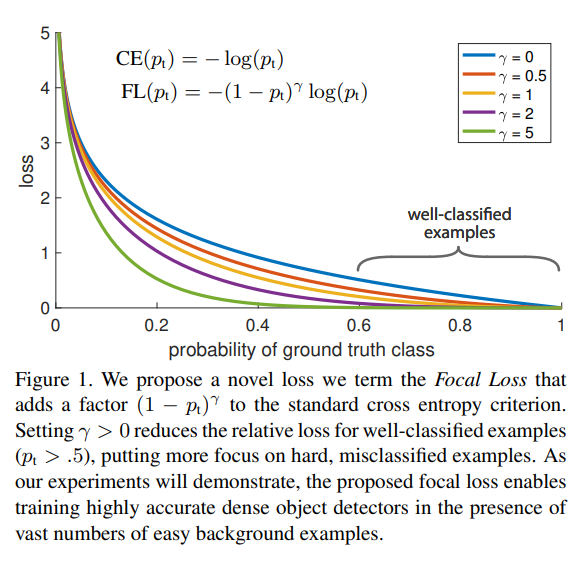

**Focal Loss와 CE 기반**

- Focal loss는 기존의 **교차 엔트로피(cross-entropy, CE)** 를 기반으로 만들어짐.
- Focal loss는 교차 엔트로피 $CE(p_t)$ 에 앞단에 간단히 **modulating factor $(1 - p_t)^\gamma$** 를 곱해 확장한 형태임.

**CE 특성**

- ground truth class에 대한 확률 $p_t$가 높으면 손실이 작아짐.
- 하지만 $p_t$가 1에 매우 가깝지 않으면 손실이 크게 발생함.
- 1-stage detection 모델 학습 시 대부분의 이미지가 배경으로 이루어져 있어 **class imbalance** 문제 발생.

**Focal loss의 역할**

- 너무 많은 배경 class에 압도되지 않도록 **modulating factor $(1 - p_t)^\gamma$** 로 손실 조절
- $\gamma = 0$이면 modulating factor가 1이 되어 일반 교차 엔트로피와 동일
- $\gamma$가 커질수록 손실 조절 효과가 강해져, **어려운 샘플**에 학습 집중



### 3-2. FPN(Feature Pyramid Network)
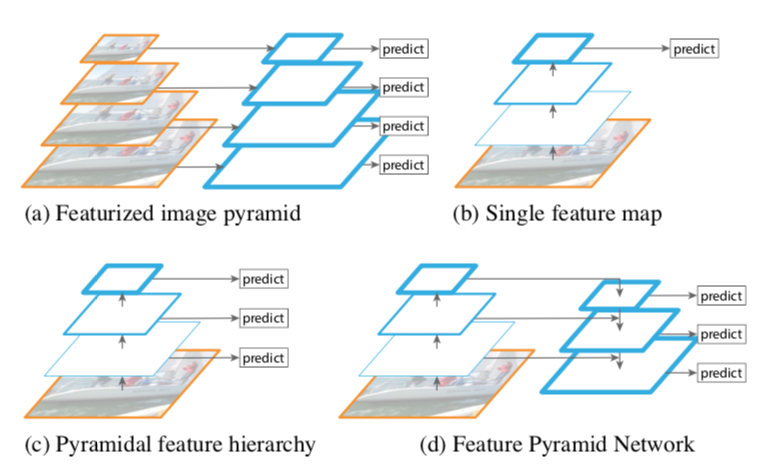

**FPN (Feature Pyramid Network) 개념**

- FPN은 특성을 **피라미드처럼 쌓아서 사용하는 방식**임.
- CNN 백본 네트워크에서는 다양한 레이어의 결과값을 **feature map** 으로 활용 가능.
- 컨볼루션 연산은 커널을 통해 일정 영역을 보고 정보를 요약하기 때문에,
  - **입력 이미지와 먼 뒷쪽 레이어의 특성 맵**: 하나의 "cell"이 넓은 이미지 영역 정보 포함
  - **입력 이미지와 가까운 앞쪽 레이어의 특성 맵**: 좁은 범위 정보 포함
- 이를 **receptive field**라고 함. 레이어가 깊어질수록 pooling을 거쳐 넓은 범위의 receptive field를 가짐.

**FPN의 핵심 아이디어**

- 백본의 여러 레이어를 **한꺼번에 활용**하겠다는 것에 의의
- SSD: 각 레이어 특성 맵에서 다양한 크기 결과를 얻음
- RetinaNet: **receptive field가 넓은 뒷쪽 특성 맵을 upsampling**하여 앞단 특성 맵과 합쳐서 사용
- 즉, 레이어 깊이에 따라 **넓게 보는 것과 좁게 보는 것**을 동시에 활용

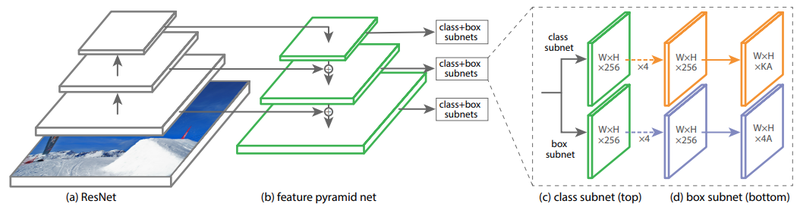

**RetinaNet에서의 FPN 활용**

- 위 그림은 RetinaNet 논문에서 **FPN 구조 적용**을 설명한 그림임.
- RetinaNet에서는 FPN을 통해 $P_3$ 부터 $P_7$ 까지의 **pyramid level**을 생성하여 사용
- 각 pyramid level은 **256개의 채널**로 구성
- 이를 기반으로 **Classification Subnet**과 **Box Regression Subnet** 2개의 Subnet 구성

**Subnet 채널 구성**

- Anchor 갯수를 $A$라고 하면:
  - **Classification Subnet**: $K$개 class에 대해 $K \cdot A$ 채널 사용
  - **Box Regression Subnet**: $4 \cdot A$ 채널 사용


## 4. 데이터 준비

### 4-1. 데이터 파이프 라인


In [4]:
def swap_xy(boxes):
    return torch.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], dim=-1)


In [5]:
def random_flip_horizontal(image, boxes):
    if torch.rand(1).item() > 0.5:
        image = TF.hflip(image)
        boxes = torch.stack(
            [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], dim=-1
        )

    return image, boxes

In [6]:
def resize_and_pad_image(image, training=True):
    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0

    image_shape = torch.tensor(image.shape[-2:], dtype=torch.float32)
    if training:
        min_side = torch.empty(1).uniform_(min_side_range[0], min_side_range[1]).item()
    ratio = min_side / torch.min(image_shape)
    if ratio * torch.max(image_shape) > max_side:
        ratio = max_side / torch.max(image_shape)
    image_shape = ratio * image_shape
    new_size = tuple(image_shape.round().int().tolist())

    image = TF.resize(image, new_size)

    padded_image_shape = torch.ceil(image_shape / stride) * stride
    padded_image_shape = padded_image_shape.int().tolist()
    pad_h = padded_image_shape[0] - new_size[0]
    pad_w = padded_image_shape[1] - new_size[1]

    image = F.pad(image, (0, pad_w, 0, pad_h))
    return image, torch.tensor(new_size), ratio

In [7]:
def convert_to_xywh(boxes):
    return torch.cat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0,
         boxes[..., 2:] - boxes[..., :2]],
        dim=-1
    )

In [8]:
import torchvision.transforms as transforms

def preprocess_data(image, boxes, class_ids, training=True):

    # Augmentation (Only for training)
    if training:
        # Random Horizontal Flip
        image, boxes = random_flip_horizontal(image, boxes)

        # Color Jitter
        jitter_transform = transforms.ColorJitter(
            brightness=0.2, # 밝기 변화 범위
            contrast=0.2,   # 대비 변화 범위
            saturation=0.2, # 채도 변화 범위
            hue=0.1         # 색조 변화 범위
        )
        image = jitter_transform(image)

    image, image_shape, _ = resize_and_pad_image(image, training=training)

    boxes = torch.stack(
        [
            boxes[:, 0] * image_shape[1],
            boxes[:, 1] * image_shape[0],
            boxes[:, 2] * image_shape[1],
            boxes[:, 3] * image_shape[0],
        ],
        dim=-1
    )

    boxes = convert_to_xywh(boxes)

    return image, boxes, class_ids

### 4-2. Encoding

In [9]:
class AnchorBox:
    def __init__(self, aspect_ratios=None):
        # aspect ratio 설정
        # default로 [0.5, 1.0, 2.0] 되어있었음
        # 다만 K-means로 이 값을 변형할 예정임
        self.aspect_ratios = aspect_ratios if aspect_ratios else [0.5, 1.0, 2.0]

        # Sclae 계수
        # anchor의 크기를 다양하게 만들기 위함
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        # 최종 anchor 개수 = aspect_ratio 개수 × scale 개수
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)

        # FPN에서 사용하는 stride 값 (P3~P7의 stride: 8,16,32,64,128)
        self._strides = [2 ** i for i in range(3, 8)]

        # FPN 레벨 별 anchor 기본 area (정사각형 기준)
        # P3 → 32², P4 → 64², P5 → 128², P6 → 256², P7 → 512²
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]

        # area × aspect_ratio × scale 조합으로 anchor width, height 계산
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        # 각 FPN 레벨(P3~P7)에 대한 anchor 크기 저장 리스트
        anchor_dims_all = []

        # level 별 기본 area 반복
        for area in self._areas:
            anchor_dims = []

            # aspect ratio 반복
            for ratio in self.aspect_ratios:
                # anchor_height = sqrt(area / ratio)
                # anchor_width  = area / anchor_height
                # → w * h = area, w/h = ratio 만족시키는 공식
                anchor_height = torch.sqrt(torch.tensor(area, dtype=torch.float32) / torch.tensor(ratio, dtype=torch.float32))
                anchor_width = torch.tensor(area, dtype=torch.float32) / anchor_height

                # dims = [w, h], (1,1,2) 차원으로 확장
                dims = torch.stack([anchor_width, anchor_height], dim=-1).unsqueeze(0).unsqueeze(0)

                # scale을 적용한 anchor 크기 생성
                for scale in self.scales:
                    anchor_dims.append(scale * dims)

            # 해당 레벨 anchor dims 통째로 저장 (anchor 종류 수, 2)
            anchor_dims_all.append(torch.stack(anchor_dims, dim=-2))

        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        # feature map width 만큼 0.5 간격 center 생성 (ex: 0.5, 1.5, 2.5 ...)
        rx = torch.arange(feature_width, dtype=torch.float32) + 0.5
        ry = torch.arange(feature_height, dtype=torch.float32) + 0.5

        # meshgrid로 모든 (x, y) 조합 생성
        # grid_x 크기: (H, W), grid_y: (H, W)
        grid_y, grid_x = torch.meshgrid(ry, rx, indexing='ij')

        # feature map 좌표를 stride 만큼 곱해서 원본 이미지 좌표의 center로 변환
        centers = torch.stack([grid_x, grid_y], dim=-1) * self._strides[level - 3]
        # centers shape = (H, W, 2)

        # anchor 개수만큼 center를 복제 (H, W, num_anchors, 2)
        centers = centers.unsqueeze(-2)
        centers = centers.repeat(1, 1, self._num_anchors, 1)

        # 미리 계산된 width,height dims를 feature map 크기에 맞게 복제
        dims = self._anchor_dims[level - 3].repeat(feature_height, feature_width, 1, 1)

        # center(x,y) + dims(w,h) 결합 → (H, W, num_anchors, 4)
        anchors = torch.cat([centers, dims], dim=-1)

        # (전체 anchor 개수, 4) 형태로 반환
        return anchors.view(feature_height * feature_width * self._num_anchors, 4)

    def get_anchors(self, image_height, image_width):
        # P3~P7까지 5개 FPN 레벨 anchor 생성 후 concat
        anchors = [
            self._get_anchors(
                int(image_height / 2 ** i),  # 해당 레벨 feature map height
                int(image_width / 2 ** i),   # 해당 레벨 feature map width
                i,                           # level index
            )
            for i in range(3, 8)
        ]

        # 모든 레벨 anchor concat
        return torch.cat(anchors, dim=0)


In [10]:
def convert_to_corners(boxes):
    """
    boxes: (N, 4) 형태의 텐서
      - boxes[..., :2] : 박스 중심(center_x, center_y)
      - boxes[..., 2:] : 박스 크기(width, height)

    반환값:
      - (N, 4) 형태의 텐서
      - [x1, y1, x2, y2]  (좌상단, 우하단 좌표)
    """

    # center_x - w/2, center_y - h/2 → 좌상단 코너
    # center_x + w/2, center_y + h/2 → 우하단 코너
    return torch.cat(
        [
            boxes[..., :2] - boxes[..., 2:] / 2.0,  # 좌상단
            boxes[..., :2] + boxes[..., 2:] / 2.0   # 우하단
        ],
        dim=-1,
    )


def compute_iou(boxes1, boxes2):
    """
    두 박스 세트(boxes1 vs boxes2)의 IoU를 계산.

    입력:
        boxes1: (N, 4)  → center format (cx, cy, w, h)
        boxes2: (M, 4)  → center format (cx, cy, w, h)

    출력:
        IoU: (N, M) 행렬
          → boxes1의 각 박스가 boxes2의 모든 박스와 IoU 계산됨
    """

    # (cx, cy, w, h) → (x1, y1, x2, y2)
    boxes1_corners = convert_to_corners(boxes1)  # (N, 4)
    boxes2_corners = convert_to_corners(boxes2)  # (M, 4)

    # --------------------------------------------
    # Intersection 계산
    # --------------------------------------------
    # 루트(Left-Upper corner) = max(x1, y1)
    # boxes1은 (N, 4), boxes2는 (M, 4)
    # boxes1[:, None, :2] → (N, 1, 2)
    # boxes2[:, :2]       → (M, 2)
    # 브로드캐스팅 후 (N, M, 2)
    lu = torch.maximum(
        boxes1_corners[:, None, :2],
        boxes2_corners[:, :2]
    )

    # 오른쪽-아래(Right-Down corner) = min(x2, y2)
    rd = torch.minimum(
        boxes1_corners[:, None, 2:],
        boxes2_corners[:, 2:]
    )

    # width = rd_x - lu_x
    # height = rd_y - lu_y
    # 음수가 나오면 겹치지 않은 것이므로 max(0) 처리
    intersection = torch.maximum(torch.tensor(0.0), rd - lu)

    # 겹치는 영역의 면적
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]

    # --------------------------------------------
    # 단일 박스의 면적 계산
    # --------------------------------------------
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]  # w * h
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]

    # --------------------------------------------
    # union = area1 + area2 - intersection
    # --------------------------------------------
    union_area = torch.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area,
        torch.tensor(1e-8)  # 0 division 방지
    )

    # --------------------------------------------
    # IoU = intersection / union
    # --------------------------------------------
    return torch.clamp(
        intersection_area / union_area,
        min=0.0,
        max=1.0
    )


In [11]:
class LabelEncoder:

    def __init__(self, aspect_ratios=None):
        # AnchorBox 생성 (사용자가 선택한 aspect_ratio 반영)
        self._anchor_box = AnchorBox(aspect_ratios=aspect_ratios)

        # 박스 타깃 회귀 시 사용하는 variance(scale factor)
        # RetinaNet에서 보통 [0.1, 0.1, 0.2, 0.2] 사용
        self._box_variance = torch.tensor([0.1, 0.1, 0.2, 0.2], dtype=torch.float32)

    # ---------------------------------------------------------------
    # 1) Anchor-gt 매칭
    # ---------------------------------------------------------------
    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        """
        anchor_boxes: (A, 4)  center format
        gt_boxes:     (G, 4)  center format

        - IoU 기반으로 각 anchor가 어떤 GT box와 매칭되는지 계산
        - IoU 기준:
            IoU ≥ 0.5 → Positive
            IoU < 0.4 → Negative
            그 외 → Ignore
        """

        # (A, G) IoU 행렬 계산
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)

        # 각 anchor별 최대 IoU 값
        max_iou, _ = torch.max(iou_matrix, dim=1)

        # 어떤 GT와 가장 많이 겹쳤는지 index
        matched_gt_idx = torch.argmax(iou_matrix, dim=1)

        # Positive / Negative / Ignore 마스크 구성
        positive_mask = max_iou >= match_iou
        negative_mask = max_iou < ignore_iou
        ignore_mask = ~(positive_mask | negative_mask)

        return (
            matched_gt_idx,
            positive_mask.float(),  # 1.0 = positive
            ignore_mask.float(),    # 1.0 = ignore
        )

    # ---------------------------------------------------------------
    # 2) Regression Target(box_target) 생성
    # ---------------------------------------------------------------
    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        """
        anchor_boxes      : (A, 4) center format
        matched_gt_boxes  : (A, 4) anchor와 매칭된 GT box

        - RetinaNet/SSD에서 쓰는 box regression target 방식:
            tx = (gx - ax) / aw
            ty = (gy - ay) / ah
            tw = log(gw / aw)
            th = log(gh / ah)
        """

        box_target = torch.cat(
            [
                # center 좌표 차이 / anchor 크기 → 정규화
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                # width, height 비율 로그
                torch.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            dim=-1,
        )

        # variance scale
        box_target = box_target / self._box_variance

        return box_target

    # ---------------------------------------------------------------
    # 3) 한 이미지의 라벨 인코딩 수행
    # ---------------------------------------------------------------
    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        """
        image_shape: (B, C, H, W)
        gt_boxes   : (G, 4), center format
        cls_ids    : (G,) class id
        """

        # 1) FPN 전체 anchor 생성
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])

        cls_ids = cls_ids.float()

        # 2) anchor-GT 매칭 수행
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )

        # 3) 매칭된 GT box 추출
        matched_gt_boxes = gt_boxes[matched_gt_idx]

        # 4) Regression target 계산
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)

        # 5) Classification target 구성
        matched_gt_cls_ids = cls_ids[matched_gt_idx]

        # Positive가 아니면 -1로 설정 (negative)
        cls_target = torch.where(
            positive_mask != 1.0,
            -1.0,
            matched_gt_cls_ids
        )

        # Ignore는 -2로 설정
        cls_target = torch.where(ignore_mask == 1.0, -2.0, cls_target)

        # 마지막 차원으로 확장 → (A, 1)
        cls_target = cls_target.unsqueeze(-1)

        # box regression + class label 합치기
        # 최종: (A, 5) = [tx, ty, tw, th, class]
        label = torch.cat([box_target, cls_target], dim=-1)

        return label

    # ---------------------------------------------------------------
    # 4) 배치 단위 인코딩
    # ---------------------------------------------------------------
    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        """
        batch_images: (B, C, H, W)
        gt_boxes    : (B, G, 4)
        cls_ids     : (B, G)
        """

        batch_size = batch_images.size(0)
        labels = []

        # 각 이미지에 대해 label encoding 수행
        for i in range(batch_size):
            label = self._encode_sample(batch_images.size(), gt_boxes[i], cls_ids[i])
            labels.append(label)

        # ---- 이미지 정규화 (ImageNet mean/std)
        batch_images = (batch_images - 0.485) / 0.229
        batch_images = (batch_images - 0.456) / 0.224
        batch_images = (batch_images - 0.406) / 0.225
        # ----------------------------------------

        return batch_images, torch.stack(labels, dim=0)


## 5. Model 작성
- Feature Pyramid

In [12]:
class FeaturePyramid(nn.Module):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__()
        self.backbone = backbone   # ResNet에서 C3, C4, C5 feature를 추출하는 부분

        # -----------------------------------------------------------
        # 1x1 conv: Top-down pathway에서 lateral connection 역할
        # (채널 수를 256으로 맞추는 단계)
        # -----------------------------------------------------------
        self.conv_c3_1x1 = nn.Conv2d(512, 256, 1, 1, padding=0)    # C3 → P3 준비
        self.conv_c4_1x1 = nn.Conv2d(1024, 256, 1, 1, padding=0)   # C4 → P4 준비
        self.conv_c5_1x1 = nn.Conv2d(2048, 256, 1, 1, padding=0)   # C5 → P5 준비

        # -----------------------------------------------------------
        # 3x3 conv: smoothing(conv after merge)
        # top-down + lateral 연결 후 aliasing 제거
        # -----------------------------------------------------------
        self.conv_c3_3x3 = nn.Conv2d(256, 256, 3, 1, padding=1)
        self.conv_c4_3x3 = nn.Conv2d(256, 256, 3, 1, padding=1)
        self.conv_c5_3x3 = nn.Conv2d(256, 256, 3, 1, padding=1)

        # -----------------------------------------------------------
        # C5에서 직접 추출하는 P6 (stride=2 downsample)
        # RetinaNet 구조 동일
        # -----------------------------------------------------------
        self.conv_c6_3x3 = nn.Conv2d(
            2048, 256, kernel_size=3, stride=2, padding=1
        )

        # -----------------------------------------------------------
        # P6을 downsample해서 P7 생성
        # ReLU 후 stride=2 conv
        # -----------------------------------------------------------
        self.conv_c7_3x3 = nn.Conv2d(
            256, 256, kernel_size=3, stride=2, padding=1
        )

        # Upsampling: top-down pathway (P5 → P4 → P3)
        self.upsample_2x = nn.Upsample(scale_factor=2, mode='nearest')

    # ------------------------------------------------------------------------
    # forward: 이미지로부터 P3, P4, P5, P6, P7 feature map 생성
    # ------------------------------------------------------------------------
    def forward(self, images):
        # backbone(images) → C3, C4, C5 출력 받음
        # ResNet50의 경우:
        # C3: stride 8,  512 channels
        # C4: stride 16, 1024 channels
        # C5: stride 32, 2048 channels
        c3_output, c4_output, c5_output = self.backbone(images)

        # ------------------------------
        # (1) C3, C4, C5 → 1x1 conv
        # ------------------------------
        p3_output = self.conv_c3_1x1(c3_output)   # lateral feature
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)

        # ------------------------------
        # (2) Top-down pathway
        #    P5 → upsample → merge C4
        #    P4 → upsample → merge C3
        # ------------------------------
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)

        # ------------------------------
        # (3) 3x3 conv smoothing
        # ------------------------------
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)

        # ------------------------------
        # (4) P6, P7 생성
        # ------------------------------
        # P6: C5를 stride=2 conv → stride 64
        p6_output = self.conv_c6_3x3(c5_output)

        # P7: P6 ReLU 후 stride=2 conv → stride 128
        p7_output = self.conv_c7_3x3(F.relu(p6_output))

        # 최종 출력: P3~P7 (FPN 완성)
        return p3_output, p4_output, p5_output, p6_output, p7_output


In [13]:
def build_head(output_filters, bias_init):
    """
    RetinaNet의 Detection Head를 만드는 함수
    - 입력 채널: 256
    - Conv3x3 + ReLU를 4회 반복하여 특징을 처리
    - 마지막 레이어에서 anchor별 출력 생성
    - weight와 bias 초기화를 RetinaNet 논문 기준으로 수행
    """
    layers = []

    # 4개의 Conv3x3 + ReLU 블록 생성
    for _ in range(4):
        conv = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        # 가중치 초기화: Normal(0, 0.01)
        torch.nn.init.normal_(conv.weight, mean=0.0, std=0.01)
        # bias 초기화: 0
        torch.nn.init.zeros_(conv.bias)
        layers.append(conv)
        layers.append(nn.ReLU())

    # 마지막 Conv 레이어: 출력 채널 수 = anchor 수 * 클래스 수 or 4 (bbox)
    final_conv = nn.Conv2d(256, output_filters, kernel_size=3, stride=1, padding=1)
    torch.nn.init.normal_(final_conv.weight, mean=0.0, std=0.01)

    # bias 초기화
    # classification head는 prior probability 기반 bias 설정 가능
    bias_init = 0.0 if bias_init == "zeros" else bias_init
    final_conv.bias.data.fill_(bias_init)

    layers.append(final_conv)

    # Sequential로 묶어 반환
    return nn.Sequential(*layers)


In [14]:
class ResNetBackbone(nn.Module):
    def __init__(self):
        super(ResNetBackbone, self).__init__()

        # torchvision에서 제공하는 ResNet50 불러오기
        # pretrained=True → ImageNet으로 사전 학습된 가중치 사용
        resnet = models.resnet50(pretrained=True)

        # -----------------------------
        # Stem 부분 (초기 feature 추출)
        # Conv1 → BN → ReLU → MaxPool
        # 출력 크기: 원본 이미지의 1/4 지점 (stride 4)
        # -----------------------------
        self.stem = nn.Sequential(
            resnet.conv1,  # 7x7 Conv (stride 2)
            resnet.bn1,
            resnet.relu,
            resnet.maxpool  # stride 2 → feature map downsample
        )

        # -----------------------------
        # ResNet의 각 stage를 그대로 가져옴
        # -----------------------------
        # layer1의 출력: C2 (256채널)
        # layer2의 출력: C3 (512채널)
        # layer3의 출력: C4 (1024채널)
        # layer4의 출력: C5 (2048채널)
        self.layer1 = resnet.layer1  # produces C2
        self.layer2 = resnet.layer2  # produces C3
        self.layer3 = resnet.layer3  # produces C4
        self.layer4 = resnet.layer4  # produces C5

    def forward(self, x):
        # Stem 통과
        x = self.stem(x)

        # ResNet 계층별로 순차적으로 입력 전달
        c2 = self.layer1(x)      # C2: FPN에서는 보통 사용 안 함
        c3 = self.layer2(c2)     # C3: FPN의 p3에 해당
        c4 = self.layer3(c3)     # C4: FPN의 p4에 해당
        c5 = self.layer4(c4)     # C5: FPN의 p5에 해당

        # FPN에서는 C3, C4, C5만 사용됨
        return c3, c4, c5


def get_backbone():
    """
    Backbone 생성 함수
    - 외부에서 간단하게 ResNet50 backbone을 가져갈 수 있게 제공
    """
    return ResNetBackbone()


In [15]:
class RetinaNet(nn.Module):
    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__()
        # FPN 생성
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        # classification head bias 초기값
        prior_probability = -torch.log(torch.tensor((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def forward(self, image):
        # FPN 통과 → 5개 feature map 생성 (P3~P7)
        features = self.fpn(image)
        N = image.size(0)

        cls_outputs = []
        box_outputs = []

        # 각 feature map에 head 적용
        for feature in features:
            # bbox 회귀
            box_outputs.append(self.box_head(feature).view(N, -1, 4))
            # 클래스 예측
            cls_outputs.append(self.cls_head(feature).view(N, -1, self.num_classes))

        # 모든 레벨 concat
        cls_outputs = torch.cat(cls_outputs, dim=1)
        box_outputs = torch.cat(box_outputs, dim=1)

        # 최종 output: [bbox(4) + class logits(num_classes)]
        return torch.cat([box_outputs, cls_outputs], dim=-1)


In [16]:
class RetinaNetBoxLoss(nn.Module):
    """Bounding Box 회귀용 Smooth L1 Loss"""
    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__()
        self._delta = delta

    def forward(self, y_true, y_pred):
        # difference 계산
        difference = y_true - y_pred
        absolute_difference = torch.abs(difference)
        squared_difference = difference ** 2

        # Smooth L1 Loss 적용
        loss = torch.where(
            absolute_difference < self._delta,
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        # anchor 차원 합
        return torch.sum(loss, dim=-1)


class RetinaNetClassificationLoss(nn.Module):
    """Classification용 Focal Loss"""
    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__()
        self._alpha = alpha
        self._gamma = gamma

    def forward(self, y_true, y_pred):
        # Binary cross-entropy 계산
        cross_entropy = F.binary_cross_entropy_with_logits(y_pred, y_true, reduction='none')
        probs = torch.sigmoid(y_pred)

        # alpha balancing 적용
        alpha = torch.where(y_true == 1.0, self._alpha, 1.0 - self._alpha)

        # pt 계산 (positive/negative)
        pt = torch.where(y_true == 1.0, probs, 1 - probs)

        # Focal Loss
        loss = alpha * torch.pow(1.0 - pt, self._gamma) * cross_entropy
        return torch.sum(loss, dim=-1)


class RetinaNetLoss(nn.Module):
    """전체 RetinaNet Loss: Focal Loss + Smooth L1"""
    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__()
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def forward(self, y_true, y_pred):
        # -------------------------------
        # 1) box regression loss
        # -------------------------------
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]

        # -------------------------------
        # 2) classification loss
        # -------------------------------
        targets = y_true[:, :, 4].long()  # 클래스 인덱스
        valid_mask = (targets >= 0)       # positive + negative mask
        safe_targets = targets * valid_mask

        # one-hot encoding
        cls_labels = F.one_hot(safe_targets, num_classes=self._num_classes).float()
        cls_labels = cls_labels * valid_mask.unsqueeze(-1).float()  # ignore 처리

        cls_predictions = y_pred[:, :, 4:]

        # positive / ignore mask
        positive_mask = (y_true[:, :, 4] > -1.0).float()
        ignore_mask = (y_true[:, :, 4] == -2.0).float()

        # -------------------------------
        # 3) 각 loss 계산
        # -------------------------------
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)

        # ignore mask 처리: ignore anchor는 classification loss 0
        clf_loss = torch.where(ignore_mask == 1.0, torch.zeros_like(clf_loss), clf_loss)

        # positive anchor만 box loss 적용
        box_loss = torch.where(positive_mask == 1.0, box_loss, torch.zeros_like(box_loss))

        # -------------------------------
        # 4) normalize by positive anchors
        # -------------------------------
        normalizer = torch.sum(positive_mask, dim=-1)
        normalizer = torch.clamp(normalizer, min=1.0)  # divide by zero 방지

        clf_loss = torch.div(torch.sum(clf_loss, dim=-1), normalizer)
        box_loss = torch.div(torch.sum(box_loss, dim=-1), normalizer)

        # -------------------------------
        # 5) 최종 loss 합
        # -------------------------------
        loss = clf_loss + box_loss
        return loss


## 6. Model 학습

In [17]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 201MB/s] 


In [18]:

class DecodePredictions(nn.Module):
    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2],
        aspect_ratios=None,
        pre_nms_topk=1000
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections = max_detections
        self._anchor_box = AnchorBox(aspect_ratios=aspect_ratios)
        self._box_variance = torch.tensor(box_variance, dtype=torch.float32)
        self.pre_nms_topk = pre_nms_topk

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance.to(box_predictions.device)
        boxes = torch.cat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, :2] + anchor_boxes[:, :, :2],
                torch.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            dim=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def forward(self, images, predictions):
        image_shape = images.shape
        anchor_boxes = self._anchor_box.get_anchors(image_shape[2], image_shape[3])
        box_predictions = predictions[:, :, :4]
        anchor_boxes = anchor_boxes.to(box_predictions.device)

        cls_predictions = torch.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        results = []
        for i in range(boxes.shape[0]):
            boxes_i = boxes[i]
            scores_i = cls_predictions[i]

            per_image_boxes = []
            per_image_scores = []
            per_image_labels = []

            for class_id in range(self.num_classes):
                class_scores = scores_i[:, class_id]
                mask = class_scores > self.confidence_threshold
                if mask.sum() == 0:
                    continue

                class_boxes = boxes_i[mask]
                class_scores_filtered = class_scores[mask]

                if class_scores_filtered.shape[0] > self.pre_nms_topk:
                    topk_scores, topk_indices = torch.topk(class_scores_filtered, self.pre_nms_topk)
                    class_boxes = class_boxes[topk_indices]
                    class_scores_filtered = topk_scores

                keep = nms(class_boxes, class_scores_filtered, self.nms_iou_threshold)

                per_image_boxes.append(class_boxes[keep])
                per_image_scores.append(class_scores_filtered[keep])
                per_image_labels.append(torch.full_like(class_scores_filtered[keep], class_id, dtype=torch.int64))

            if len(per_image_boxes) > 0:
                img_boxes = torch.cat(per_image_boxes, dim=0)
                img_scores = torch.cat(per_image_scores, dim=0)
                img_labels = torch.cat(per_image_labels, dim=0)

                if img_boxes.shape[0] > self.max_detections:
                    scores_sorted, indices = torch.sort(img_scores, descending=True)
                    indices = indices[:self.max_detections]
                    img_boxes = img_boxes[indices]
                    img_scores = scores_sorted[:self.max_detections]
                    img_labels = img_labels[indices]
            else:
                img_boxes = torch.empty((0, 4), device=boxes.device)
                img_scores = torch.empty((0,), device=boxes.device)
                img_labels = torch.empty((0,), device=boxes.device, dtype=torch.int64)

            results.append({
                'boxes': img_boxes,
                'scores': img_scores,
                'labels': img_labels
            })
        return results

def run_evaluation(model, val_loader, device, aspect_ratios=None):
    model.eval()
    metric = MeanAveragePrecision()

    decoder = DecodePredictions(confidence_threshold=0.005, aspect_ratios=aspect_ratios)

    with torch.no_grad():
        for images, _, targets in val_loader:
            images = images.to(device)
            outputs = model(images)
            results = decoder(images, outputs)

            preds = []
            for res in results:
                preds.append({
                    'boxes': res['boxes'].cpu(),
                    'scores': res['scores'].cpu(),
                    'labels': res['labels'].cpu()
                })

            target_list = []
            for t in targets:
                gt_boxes = convert_to_corners(t['boxes'])
                target_list.append(
                    dict(
                        boxes=gt_boxes.cpu(),
                        labels=t['labels'].cpu()
                    )
                )

            metric.update(preds, target_list)

    return metric.compute()

learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rates[0], momentum=0.9)

def lr_lambda(epoch):
    for i, boundary in enumerate(learning_rate_boundaries):
        if epoch < boundary:
            return learning_rates[i] / learning_rates[0]
    return learning_rates[-1] / learning_rates[0]

scheduler = LambdaLR(optimizer, lr_lambda)

In [19]:

train_data_dir = 'KITTY/training/training'

class KITTIDataset(Dataset):
    def __init__(self, root_dir, split='train', label_encoder=None, transform=True, load_image_data=True):
        self.img_dir = os.path.join(root_dir, "image_2")
        self.label_dir = os.path.join(root_dir, "label_2")
        self.split = split
        self.load_image_data = load_image_data

        all_files = sorted([os.path.basename(f) for f in glob.glob(os.path.join(self.img_dir, '*.png'))])

        split_idx = int(len(all_files) * 0.8)
        if split == 'train':
            self.filenames = all_files[:split_idx]
        else:
            self.filenames = all_files[split_idx:]

        self.label_encoder = label_encoder
        self.transform = transform

        self.class_dict = {
            'Car': 0, 'Van': 1, 'Truck': 2, 'Pedestrian': 3,
            'Person_sitting': 4, 'Cyclist': 5, 'Tram': 6, 'Misc': 7
        }

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        img_path = os.path.join(self.img_dir, filename)
        label_path = os.path.join(self.label_dir, filename.replace('.png', '.txt'))

        if self.load_image_data:
            image = Image.open(img_path).convert("RGB")
            w, h = image.size
            image = TF.to_tensor(image)
        else:
            image = torch.zeros(1)
            w, h = 1.0, 1.0

        boxes = []
        labels = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    cls_name = parts[0]
                    if cls_name in self.class_dict:
                        l, t, r, b = map(float, parts[4:8])

                        if self.load_image_data:
                            boxes.append([l/w, t/h, r/w, b/h])
                        else:
                            boxes.append([l, t, r, b])

                        labels.append(self.class_dict[cls_name])

        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int32)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int32)

        if self.load_image_data:
            if self.transform:
                is_training = (self.split == 'train')
                image, boxes, labels = preprocess_data(image, boxes, labels, training=is_training)

            if self.label_encoder:
                encoded_label = self.label_encoder._encode_sample(image.shape, boxes, labels)
            else:
                encoded_label = (boxes, labels)

            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            image = (image - mean) / std
        else:
            encoded_label = (boxes, labels)

        target = {'boxes': boxes, 'labels': labels}
        return image, encoded_label, target

def collate_fn(batch):
    images, encoded_labels, targets = zip(*batch)

    if len(images[0].shape) == 3:
        max_width = max(img.shape[1] for img in images)
        max_height = max(img.shape[0] for img in images)
        pad_value = 0.0

        padded_images = []
        for img in images:
            pad_h = max_height - img.shape[0]
            pad_w = max_width - img.shape[1]
            padded_img = F.pad(img, (0, pad_w, 0, pad_h), value=pad_value)
            padded_images.append(padded_img)
        images = torch.stack(padded_images)
    else:
        images = list(images)

    encoded_labels = torch.stack(encoded_labels) if isinstance(encoded_labels[0], torch.Tensor) else list(encoded_labels)
    return images, encoded_labels, targets


In [20]:
# --- K-Means로 최적 Anchor 비율 찾기 ---
# 기존 Anchor Box는 [0.5, 1.0, 2.0]으로 기본 설정되어 있었는데, 데이터에 더 맞게끔 설정하기 위하여
# K-Means를 사용하여 비율을 찾는 방법이 있다고 하여 진행
# 수치상으로는 그렇게 차이가 나보이진 않지만, 어쨌든 데이터의 BBox 비율을 만들어주어
# 학습에 좀 더 도움이 되지 않을 까 생각이 듬
# 결과 : [0.530, 1.367, 2.438]

# Node에서 Anchor에서 Matching 개념이 나올때
# 설정한 anchor box에 비해 실제 객체가 더 크거나 더 작거나 할 경우
# 실제 Label인 BBox와 매칭되기가 힘들다. (IoU 점수 비교가 굉장히 힘들 것으로 보임)
# 그래서 진행했음

ratios_path = os.path.join(save_dir, 'optimal_ratios.txt')

if os.path.exists(ratios_path):
    print(f"Loading optimal anchor ratios from {ratios_path}...")
    with open(ratios_path, 'r') as f:
        content = f.read().strip()
        optimal_ratios = [float(x) for x in content.split(',')]
    print(f"Optimal Aspect Ratios: {optimal_ratios}")
else:
    print("Computing optimal anchor ratios using K-Means...")
    temp_dataset = KITTIDataset(train_data_dir, split='train', label_encoder=None, transform=False, load_image_data=False)


    temp_loader = DataLoader(
        temp_dataset,
        batch_size=64,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=4
    )

    ratios = []
    # DataLoader를 순회하며 박스 정보 수집
    for _, _, targets in tqdm(temp_loader, desc="Collecting boxes"):
        for t in targets:
            boxes = t['boxes']
            if len(boxes) > 0:
                w = boxes[:, 2] - boxes[:, 0]
                h = boxes[:, 3] - boxes[:, 1]
                # w / h 비율 계산
                r = w / torch.clamp(h, min=1e-6)
                ratios.append(r.numpy())

    if len(ratios) > 0:
        all_ratios = np.concatenate(ratios)
        kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
        kmeans.fit(all_ratios.reshape(-1, 1))
        optimal_ratios = sorted(kmeans.cluster_centers_.reshape(-1).tolist())
        print(f"\nOptimal Aspect Ratios: {optimal_ratios}")

        with open(ratios_path, 'w') as f:
            f.write(','.join(map(str, optimal_ratios)))
        print(f"Saved optimal ratios to {ratios_path}")
    else:
        print("\nNo boxes found, using default ratios.")
        optimal_ratios = [0.5, 1.0, 2.0]

Loading optimal anchor ratios from KITTY/optimal_ratios.txt...
Optimal Aspect Ratios: [0.530328631401062, 1.3673322200775146, 2.4388959407806396]


In [21]:
label_encoder = LabelEncoder(aspect_ratios=optimal_ratios)

train_dataset = KITTIDataset(train_data_dir, split='train', label_encoder=label_encoder, load_image_data=True)
val_dataset = KITTIDataset(train_data_dir, split='val', label_encoder=label_encoder, load_image_data=True)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn, num_workers=0
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, drop_last=True, collate_fn=collate_fn, num_workers=0
)

print(f" train data 개수 : {len(train_loader)}")
print(f" valid data 개수 : {len(val_loader)}")

 train data 개수 : 2992
 valid data 개수 : 748


Visualizing a sample from Training Loader...


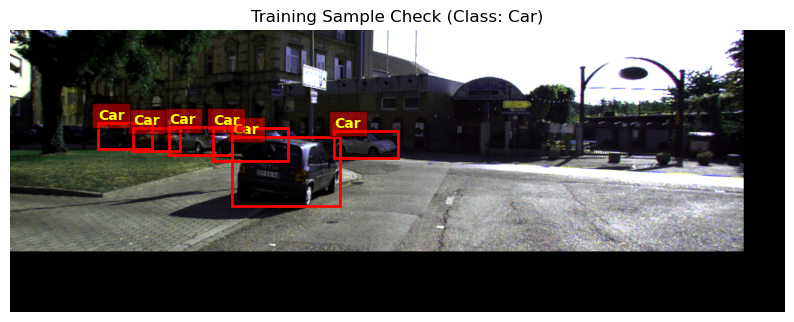

In [26]:
# 학습 시에 loss와 mAP 수치가 이상하여
# Loader에 있는 이미지가 정상적으로 Labling이 되어있는지 보기 위해....

def visualize_training_sample(loader, index=0):
    images, encoded_labels, targets = next(iter(loader))

    image = images[index]
    target = targets[index]

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = image * std + mean
    image = torch.clamp(image, 0, 1)
    image = image.permute(1, 2, 0).cpu().numpy()

    boxes_xywh = target['boxes']
    boxes_x1y1x2y2 = convert_to_corners(boxes_xywh)
    labels = target['labels']

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    h, w, _ = image.shape

    for box, label in zip(boxes_x1y1x2y2, labels):
        x1, y1, x2, y2 = box.tolist()
        cls_name = list(train_dataset.class_dict.keys())[list(train_dataset.class_dict.values()).index(label.item())]

        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1-5, cls_name, color='yellow', fontsize=10, fontweight='bold', bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.title(f"Training Sample Check (Class: {cls_name})")
    plt.show()

print("Visualizing a sample from Training Loader...")
visualize_training_sample(train_loader, index=0)

In [27]:
# 이전 코랩에서 돌리던 학습 진행상황

# No checkpoint found. Starting training from scratch.
# Start Training...
# Train Epoch: 1 [0/5984 (0%)]	Loss: 3.878126
# Train Epoch: 1 [2000/5984 (33%)]	Loss: 3.865422
# Train Epoch: 1 [4000/5984 (67%)]	Loss: 3.960004
# Running Evaluation...

# Epoch 1 Summary:
# Train | Loss: 3.8187, mAP: 0.0000, mAP@50: 0.0000 (Subset)
# Valid | Loss: 3.7656, mAP: 0.0000, mAP@50: 0.0000
# Time  | 786.51s
# ------------------------------------------------------------
# Saved Best Loss Model (Loss: 3.7656)
# Saved Best mAP Model (mAP: 0.0000)
# Train Epoch: 2 [0/5984 (0%)]	Loss: 3.784736
# Train Epoch: 2 [2000/5984 (33%)]	Loss: 3.690502
# Train Epoch: 2 [4000/5984 (67%)]	Loss: 3.571678
# Running Evaluation...

# Epoch 2 Summary:
# Train | Loss: 3.6526, mAP: 0.0001, mAP@50: 0.0005 (Subset)
# Valid | Loss: 3.5995, mAP: 0.0001, mAP@50: 0.0006
# Time  | 788.47s
# ------------------------------------------------------------
# Saved Best Loss Model (Loss: 3.5995)
# Saved Best mAP Model (mAP: 0.0001)
# Train Epoch: 3 [0/5984 (0%)]	Loss: 3.662043
# Train Epoch: 3 [2000/5984 (33%)]	Loss: 3.520129
# Train Epoch: 3 [4000/5984 (67%)]	Loss: 3.687342
# Running Evaluation...

# Epoch 3 Summary:
# Train | Loss: 3.5762, mAP: 0.0002, mAP@50: 0.0009 (Subset)
# Valid | Loss: 3.5424, mAP: 0.0002, mAP@50: 0.0010
# Time  | 790.67s
# ------------------------------------------------------------
# Saved Best Loss Model (Loss: 3.5424)
# Saved Best mAP Model (mAP: 0.0002)
# Train Epoch: 4 [0/5984 (0%)]	Loss: 3.570710
# Train Epoch: 4 [2000/5984 (33%)]	Loss: 3.459814
# Train Epoch: 4 [4000/5984 (67%)]	Loss: 3.624976
# Running Evaluation...

# Epoch 4 Summary:
# Train | Loss: 3.5440, mAP: 0.0004, mAP@50: 0.0023 (Subset)
# Valid | Loss: 3.4997, mAP: 0.0005, mAP@50: 0.0024
# Time  | 792.10s
# ------------------------------------------------------------
# Saved Best Loss Model (Loss: 3.4997)
# Saved Best mAP Model (mAP: 0.0005)
# Train Epoch: 5 [0/5984 (0%)]	Loss: 3.422859
# Train Epoch: 5 [2000/5984 (33%)]	Loss: 3.692137
# Train Epoch: 5 [4000/5984 (67%)]	Loss: 3.529682
# Running Evaluation...

# Epoch 5 Summary:
# Train | Loss: 3.5064, mAP: 0.0006, mAP@50: 0.0028 (Subset)
# Valid | Loss: 3.4706, mAP: 0.0007, mAP@50: 0.0032
# Time  | 791.85s
# ------------------------------------------------------------
# Saved Best Loss Model (Loss: 3.4706)
# Saved Best mAP Model (mAP: 0.0007)
# Train Epoch: 6 [0/5984 (0%)]	Loss: 3.447944
# Train Epoch: 6 [2000/5984 (33%)]	Loss: 3.391273
# Train Epoch: 6 [4000/5984 (67%)]	Loss: 3.432163
# Running Evaluation...

# Epoch 6 Summary:
# Train | Loss: 3.4632, mAP: 0.0008, mAP@50: 0.0027 (Subset)
# Valid | Loss: 3.4186, mAP: 0.0008, mAP@50: 0.0035
# Time  | 790.07s
# ------------------------------------------------------------
# Saved Best Loss Model (Loss: 3.4186)
# Saved Best mAP Model (mAP: 0.0008)
# Train Epoch: 7 [0/5984 (0%)]	Loss: 3.402578
# Train Epoch: 7 [2000/5984 (33%)]	Loss: 3.140656
# Train Epoch: 7 [4000/5984 (67%)]	Loss: 3.501536
# Running Evaluation...

# Epoch 7 Summary:
# Train | Loss: 3.4065, mAP: 0.0017, mAP@50: 0.0051 (Subset)
# Valid | Loss: 3.3933, mAP: 0.0017, mAP@50: 0.0058
# Time  | 789.60s
# ------------------------------------------------------------
# Saved Best Loss Model (Loss: 3.3933)
# Saved Best mAP Model (mAP: 0.0017)
# Train Epoch: 8 [0/5984 (0%)]	Loss: 3.450443
# Train Epoch: 8 [2000/5984 (33%)]	Loss: 3.282242
# Train Epoch: 8 [4000/5984 (67%)]	Loss: 3.430085
# Running Evaluation...

# Epoch 8 Summary:
# Train | Loss: 3.3475, mAP: 0.0019, mAP@50: 0.0060 (Subset)
# Valid | Loss: 3.2819, mAP: 0.0015, mAP@50: 0.0065
# Time  | 792.08s
# ------------------------------------------------------------
# Saved Best Loss Model (Loss: 3.2819)
# Train Epoch: 9 [0/5984 (0%)]	Loss: 3.299923
# Train Epoch: 9 [2000/5984 (33%)]	Loss: 3.046568
# Train Epoch: 9 [4000/5984 (67%)]	Loss: 3.408216
# Running Evaluation...

# Epoch 9 Summary:
# Train | Loss: 3.2649, mAP: 0.0021, mAP@50: 0.0069 (Subset)
# Valid | Loss: 3.2149, mAP: 0.0020, mAP@50: 0.0071
# Time  | 789.74s
# ------------------------------------------------------------
# Saved Best Loss Model (Loss: 3.2149)
# Saved Best mAP Model (mAP: 0.0020)
# Train Epoch: 10 [0/5984 (0%)]	Loss: 3.125103
# Train Epoch: 10 [2000/5984 (33%)]	Loss: 3.156182
# Train Epoch: 10 [4000/5984 (67%)]	Loss: 3.167840
# Running Evaluation...

# Epoch 10 Summary:
# Train | Loss: 3.2192, mAP: 0.0019, mAP@50: 0.0064 (Subset)
# Valid | Loss: 3.2248, mAP: 0.0018, mAP@50: 0.0060
# Time  | 788.21s
# ------------------------------------------------------------
# Train Epoch: 11 [0/5984 (0%)]	Loss: 3.175942
# Train Epoch: 11 [2000/5984 (33%)]	Loss: 3.353548
# Train Epoch: 11 [4000/5984 (67%)]	Loss: 3.298490
# Running Evaluation...

# Epoch 11 Summary:
# Train | Loss: 3.1828, mAP: 0.0024, mAP@50: 0.0083 (Subset)
# Valid | Loss: 3.1630, mAP: 0.0023, mAP@50: 0.0078
# Time  | 789.86s
# ------------------------------------------------------------
# Saved Best Loss Model (Loss: 3.1630)
# Saved Best mAP Model (mAP: 0.0023)
# Train Epoch: 12 [0/5984 (0%)]	Loss: 3.257466
# Train Epoch: 12 [2000/5984 (33%)]	Loss: 3.070161
# Train Epoch: 12 [4000/5984 (67%)]	Loss: 3.113491
# Running Evaluation...

# Epoch 12 Summary:
# Train | Loss: 3.1455, mAP: 0.0027, mAP@50: 0.0081 (Subset)
# Valid | Loss: 3.1368, mAP: 0.0027, mAP@50: 0.0079
# Time  | 791.04s
# ------------------------------------------------------------
# Saved Best Loss Model (Loss: 3.1368)
# Saved Best mAP Model (mAP: 0.0027)
# Train Epoch: 13 [0/5984 (0%)]	Loss: 3.191230
# Train Epoch: 13 [2000/5984 (33%)]	Loss: 3.046226
# Train Epoch: 13 [4000/5984 (67%)]	Loss: 3.170759
# Running Evaluation...

# Epoch 13 Summary:
# Train | Loss: 3.1129, mAP: 0.0027, mAP@50: 0.0075 (Subset)
# Valid | Loss: 3.1112, mAP: 0.0024, mAP@50: 0.0074
# Time  | 791.74s
# ------------------------------------------------------------
# Saved Best Loss Model (Loss: 3.1112)
# Train Epoch: 14 [0/5984 (0%)]	Loss: 3.114568
# Train Epoch: 14 [2000/5984 (33%)]	Loss: 2.796615
# Train Epoch: 14 [4000/5984 (67%)]	Loss: 3.056270
# Running Evaluation...

# Epoch 14 Summary:
# Train | Loss: 3.0845, mAP: 0.0028, mAP@50: 0.0081 (Subset)
# Valid | Loss: 3.1111, mAP: 0.0025, mAP@50: 0.0077
# Time  | 789.54s
# ------------------------------------------------------------
# Saved Best Loss Model (Loss: 3.1111)
# Train Epoch: 15 [0/5984 (0%)]	Loss: 2.713163
# Train Epoch: 15 [2000/5984 (33%)]	Loss: 3.048654
# Train Epoch: 15 [4000/5984 (67%)]	Loss: 2.359350
# Running Evaluation...

# Epoch 15 Summary:
# Train | Loss: 3.0499, mAP: 0.0031, mAP@50: 0.0099 (Subset)
# Valid | Loss: 3.0943, mAP: 0.0028, mAP@50: 0.0086
# Time  | 789.08s
# ------------------------------------------------------------
# Saved Best Loss Model (Loss: 3.0943)
# Saved Best mAP Model (mAP: 0.0028)
# Train Epoch: 16 [0/5984 (0%)]	Loss: 3.289270
# Train Epoch: 16 [2000/5984 (33%)]	Loss: 2.863165
# Train Epoch: 16 [4000/5984 (67%)]	Loss: 3.031880
# Running Evaluation...

# Epoch 16 Summary:
# Train | Loss: 3.0185, mAP: 0.0027, mAP@50: 0.0068 (Subset)
# Valid | Loss: 3.0767, mAP: 0.0022, mAP@50: 0.0060
# Time  | 789.46s
# ------------------------------------------------------------

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

epochs = 50
log_interval = 1000

save_path = os.path.join(save_dir, 'checkpoint_latest.pth')
print(save_path)

# Train mAP 계산을 위한 Subset Loader
# Loss 외에 잘 쓰이는 Metric으로 Mean Average Precision으로 선정
# 다만 훈련 데이터 전부를 계산하게 되면 연산량이 늘어난다고 하여 일부만 추출하여 진행 - 안그래도 mAP추가하고 확실히 더 느려짐이 체감됨 3~5분정도?
# 물론 검증용인 Valid 데이터는 전부 사용해서 계산함

# 모델 학습 겸 epoch의 checkpoint와 best model의 checkpoint 전부 추가
# 안전을 위해.... colab을 돌리다가 사용량으로 인해 LMS로 옴

num_train_eval = 500
indices = torch.randperm(len(train_dataset))[:num_train_eval]
train_subset_dataset = Subset(train_dataset, indices)

train_eval_loader = DataLoader(
    train_subset_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0
)

# 기본값 초기화
start_epoch = 1
train_loss_history = []
val_loss_history = []
train_map_history = []
train_map_50_history = []
val_map_history = []
val_map_50_history = []
best_val_loss = float('inf')
best_map = -1.0

# --- Resume Logic ---
if os.path.exists(save_path):
    try:
        print(f"Loading checkpoint from {save_path}...")
        checkpoint = torch.load(save_path)

        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if 'scheduler_state_dict' in checkpoint:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        start_epoch = checkpoint['epoch'] + 1
        train_loss_history = checkpoint.get('train_loss_history', [])
        val_loss_history = checkpoint.get('val_loss_history', [])

        if 'map_history' in checkpoint:
            val_map_history = checkpoint['map_history']
            val_map_50_history = checkpoint['map_50_history']
        else:
            val_map_history = checkpoint.get('val_map_history', [])
            val_map_50_history = checkpoint.get('val_map_50_history', [])

        train_map_history = checkpoint.get('train_map_history', [])
        train_map_50_history = checkpoint.get('train_map_50_history', [])

        if val_loss_history:
            best_val_loss = min(val_loss_history)
        if val_map_history:
            best_map = max(val_map_history)

        print(f"> Resuming training from epoch {start_epoch}")
        print(f"> Best Val Loss: {best_val_loss:.4f}, Best Val mAP: {best_map:.4f}")
    except Exception as e:
        print(f"! Failed to load checkpoint: {e}")
        print("! Starting training from scratch.")
else:
    print("No checkpoint found. Starting training from scratch.")


print("Start Training...")
for epoch in range(start_epoch, epochs + 1):
    # --- Training Phase ---
    model.train()

    total_train_loss = 0
    start_time = time.time()

    for batch_idx, (images, encoded_labels, targets) in enumerate(train_loader):
        images = images.to(device)
        encoded_labels = encoded_labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(encoded_labels, outputs)
        loss = loss.mean()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    print("Running Evaluation...")

    # Train mAP (Subset)
    train_results = run_evaluation(model, train_eval_loader, device, aspect_ratios=optimal_ratios)
    train_map = train_results['map'].item()
    train_map_50 = train_results['map_50'].item()
    train_map_history.append(train_map)
    train_map_50_history.append(train_map_50)

    # Validation Loss & mAP
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for images, encoded_labels, targets in val_loader:
            images = images.to(device)
            encoded_labels = encoded_labels.to(device)
            outputs = model(images)
            loss = loss_fn(encoded_labels, outputs)
            loss = loss.mean()
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    val_results = run_evaluation(model, val_loader, device, aspect_ratios=optimal_ratios)
    val_map = val_results['map'].item()
    val_map_50 = val_results['map_50'].item()
    val_map_history.append(val_map)
    val_map_50_history.append(val_map_50)

    elapsed_time = time.time() - start_time
    print(f"\nEpoch {epoch} Summary:")
    print(f"Train | Loss: {avg_train_loss:.4f}, mAP: {train_map:.4f}, mAP@50: {train_map_50:.4f} (Subset)")
    print(f"Valid | Loss: {avg_val_loss:.4f}, mAP: {val_map:.4f}, mAP@50: {val_map_50:.4f}")
    print(f"Time  | {elapsed_time:.2f}s")
    print("-" * 60)

    # --- Checkpoint 저장 ---
    checkpoint_dict = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history,
        'train_map_history': train_map_history,
        'train_map_50_history': train_map_50_history,
        'val_map_history': val_map_history,
        'val_map_50_history': val_map_50_history
    }

    torch.save(checkpoint_dict, save_path)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(checkpoint_dict, os.path.join(save_dir, 'checkpoint_best_loss.pth'))
        print(f"Saved Best Loss Model (Loss: {best_val_loss:.4f})")

    if val_map > best_map:
        best_map = val_map
        torch.save(checkpoint_dict, os.path.join(save_dir, 'checkpoint_best_map.pth'))
        print(f"Saved Best mAP Model (mAP: {best_map:.4f})")

KITTY/checkpoint_latest.pth
Loading checkpoint from KITTY/checkpoint_latest.pth...
> Resuming training from epoch 17
> Best Val Loss: 3.0767, Best Val mAP: 0.0028
Start Training...
Train Epoch: 17 [0/5984 (0%)]	Loss: 3.474279
Train Epoch: 17 [2000/5984 (33%)]	Loss: 3.512099
Train Epoch: 17 [4000/5984 (67%)]	Loss: 2.803184
Running Evaluation...

Epoch 17 Summary:
Train | Loss: 3.2050, mAP: 0.0031, mAP@50: 0.0091 (Subset)
Valid | Loss: 3.1428, mAP: 0.0030, mAP@50: 0.0088
Time  | 2499.45s
------------------------------------------------------------
Saved Best mAP Model (mAP: 0.0030)
Train Epoch: 18 [0/5984 (0%)]	Loss: 3.591393
Train Epoch: 18 [2000/5984 (33%)]	Loss: 3.238006
Train Epoch: 18 [4000/5984 (67%)]	Loss: 3.018880
Running Evaluation...

Epoch 18 Summary:
Train | Loss: 3.0972, mAP: 0.0032, mAP@50: 0.0099 (Subset)
Valid | Loss: 3.0789, mAP: 0.0033, mAP@50: 0.0093
Time  | 2514.69s
------------------------------------------------------------
Saved Best mAP Model (mAP: 0.0033)
Train E

KeyboardInterrupt: 

In [ ]:
# 아래 두 주석은 이전에 했던 것들
# 본 코드에서 진행 하기 전 기본 노드에서 가져온 코드로 했을때

In [ ]:
# # 기존 노드내의 코드로 돌렸을 때 - 모델 말고 오류나는 부분만 수정 후 진행
# Epoch: 1 	Average Loss: 3.669623 	Time: 604.36s
# Epoch: 2 	Average Loss: 3.515642 	Time: 605.51s
# Epoch: 3 	Average Loss: 3.339249 	Time: 604.38s
# Epoch: 4 	Average Loss: 3.309787 	Time: 605.24s
# Epoch: 5 	Average Loss: 3.300940 	Time: 598.31s
# Epoch: 6 	Average Loss: 3.298988 	Time: 598.08s
# Epoch: 7 	Average Loss: 3.291052 	Time: 598.40s
# Epoch: 8 	Average Loss: 3.285355 	Time: 598.75s
# Epoch: 9 	Average Loss: 3.280049 	Time: 598.51s
# Epoch: 10 	Average Loss: 3.275322 	Time: 598.66s
# Epoch: 11 	Average Loss: 3.269427 	Time: 598.68s
# Epoch: 12 	Average Loss: 3.265284 	Time: 598.77s
# Epoch: 13 	Average Loss: 3.258816 	Time: 598.70s
# Epoch: 14 	Average Loss: 3.252478 	Time: 598.74s
# Epoch: 15 	Average Loss: 3.246853 	Time: 598.81s
# Epoch: 16 	Average Loss: 3.240732 	Time: 598.83s
# Epoch: 17 	Average Loss: 3.233652 	Time: 598.79s
# Epoch: 18 	Average Loss: 3.229734 	Time: 599.15s
# Epoch: 19 	Average Loss: 3.225427 	Time: 598.91s
# Epoch: 20 	Average Loss: 3.218059 	Time: 599.04s

In [ ]:
# No checkpoint found. Starting training from scratch.
# Start Training...
# Train Epoch: 1 [0/5984 (0%)]	Loss: 4.094695
# Train Epoch: 1 [2000/5984 (33%)]	Loss: 3.832446
# Train Epoch: 1 [4000/5984 (67%)]	Loss: 3.661866
# Running Evaluation...

# Epoch 1 Summary:
# Train | Loss: 3.7773, mAP: 0.0000, mAP@50: 0.0002 (Subset)
# Valid | Loss: 3.6704, mAP: 0.0000, mAP@50: 0.0002
# Time  | 782.38s
# ------------------------------------------------------------
# Saved Best Loss Model (Loss: 3.6704)
# Saved Best mAP Model (mAP: 0.0000)
# Train Epoch: 2 [0/5984 (0%)]	Loss: 3.639479
# Train Epoch: 2 [2000/5984 (33%)]	Loss: 3.578657
# Train Epoch: 2 [4000/5984 (67%)]	Loss: 3.554112
# Running Evaluation...

# Epoch 2 Summary:
# Train | Loss: 3.6146, mAP: 0.0002, mAP@50: 0.0012 (Subset)
# Valid | Loss: 3.5412, mAP: 0.0003, mAP@50: 0.0015
# Time  | 785.95s
# ------------------------------------------------------------
# Saved Best Loss Model (Loss: 3.5412)
# Saved Best mAP Model (mAP: 0.0003)
# Train Epoch: 3 [0/5984 (0%)]	Loss: 3.491874
# Train Epoch: 3 [2000/5984 (33%)]	Loss: 3.471810
# Train Epoch: 3 [4000/5984 (67%)]	Loss: 3.812048
# Running Evaluation...

# Epoch 3 Summary:
# Train | Loss: 3.5581, mAP: 0.0004, mAP@50: 0.0023 (Subset)
# Valid | Loss: 3.5398, mAP: 0.0010, mAP@50: 0.0028
# Time  | 788.34s
# ------------------------------------------------------------
# Saved Best Loss Model (Loss: 3.5398)
# Saved Best mAP Model (mAP: 0.0010)
# Train Epoch: 4 [0/5984 (0%)]	Loss: 3.539580
# Train Epoch: 4 [2000/5984 (33%)]	Loss: 3.436146
# Train Epoch: 4 [4000/5984 (67%)]	Loss: 3.514378
# Running Evaluation...

# Epoch 4 Summary:
# Train | Loss: 3.5017, mAP: 0.0012, mAP@50: 0.0040 (Subset)
# Valid | Loss: 3.4533, mAP: 0.0007, mAP@50: 0.0027
# Time  | 788.02s
# ------------------------------------------------------------
# Saved Best Loss Model (Loss: 3.4533)
# Train Epoch: 5 [0/5984 (0%)]	Loss: 3.428757
# Train Epoch: 5 [2000/5984 (33%)]	Loss: 3.657532
# Train Epoch: 5 [4000/5984 (67%)]	Loss: 3.550882
# Running Evaluation...

# Epoch 5 Summary:
# Train | Loss: 3.4524, mAP: 0.0013, mAP@50: 0.0046 (Subset)
# Valid | Loss: 3.4299, mAP: 0.0014, mAP@50: 0.0047
# Time  | 788.74s
# ------------------------------------------------------------
# Saved Best Loss Model (Loss: 3.4299)
# Saved Best mAP Model (mAP: 0.0014)
# Train Epoch: 6 [0/5984 (0%)]	Loss: 3.428200
# Train Epoch: 6 [2000/5984 (33%)]	Loss: 3.321395
# Train Epoch: 6 [4000/5984 (67%)]	Loss: 3.494728
# Running Evaluation...

# Epoch 6 Summary:
# Train | Loss: 3.3906, mAP: 0.0016, mAP@50: 0.0061 (Subset)
# Valid | Loss: 3.3428, mAP: 0.0016, mAP@50: 0.0060
# Time  | 790.13s
# ------------------------------------------------------------
# Saved Best Loss Model (Loss: 3.3428)
# Saved Best mAP Model (mAP: 0.0016)
# Train Epoch: 7 [0/5984 (0%)]	Loss: 3.466328

In [25]:
# import torch
# import gc

# # 불필요한 변수 삭제
# del images, encoded_labels, outputs, loss
# gc.collect()

# # GPU 캐시 비우기
# torch.cuda.empty_cache()

## 7. 모델 성능 시각화

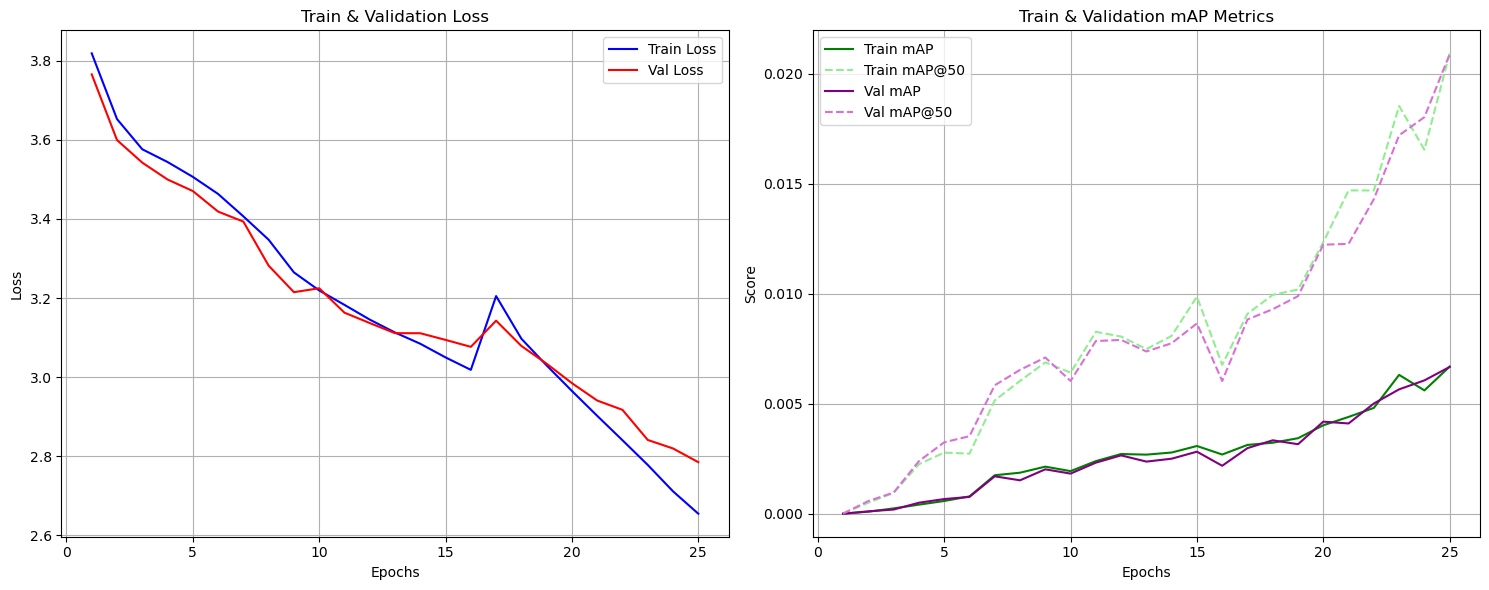

In [36]:
checkpoint_path = os.path.join(save_dir, 'checkpoint_latest.pth')

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)

    train_loss = checkpoint.get('train_loss_history', [])
    val_loss = checkpoint.get('val_loss_history', [])

    train_map = checkpoint.get('train_map_history', [])
    train_map_50 = checkpoint.get('train_map_50_history', [])
    val_map = checkpoint.get('val_map_history', [])
    val_map_50 = checkpoint.get('val_map_50_history', [])

    epochs_range = range(1, len(train_loss) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Loss Plot (Train + Val)
    axes[0].plot(epochs_range, train_loss, label='Train Loss', color='blue')
    if val_loss:
        axes[0].plot(range(1, len(val_loss) + 1), val_loss, label='Val Loss', color='red')

    axes[0].set_title('Train & Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # mAP Plot 
    if train_map:
        axes[1].plot(range(1, len(train_map) + 1), train_map, label='Train mAP', color='green')
        axes[1].plot(range(1, len(train_map_50) + 1), train_map_50, label='Train mAP@50', color='lightgreen', linestyle='--')

    if val_map:
        axes[1].plot(range(1, len(val_map) + 1), val_map, label='Val mAP', color='purple')
        axes[1].plot(range(1, len(val_map_50) + 1), val_map_50, label='Val mAP@50', color='orchid', linestyle='--')

    axes[1].set_title('Train & Validation mAP Metrics')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Score')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

else:
    print("No checkpoint found to visualize.")


## 8. 결과 확인하기

In [23]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if 'resnet50_backbone' not in locals():
    resnet50_backbone = get_backbone()

model = RetinaNet(num_classes, resnet50_backbone)
model = model.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rates[0], weight_decay=1e-4)


best_loss_path = os.path.join(save_dir, 'checkpoint_best_loss.pth')

if os.path.exists(best_loss_path):
    checkpoint = torch.load(best_loss_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    epoch = checkpoint['epoch']
    
    if 'val_loss_history' in checkpoint and len(checkpoint['val_loss_history']) > 0:
        best_loss = checkpoint['val_loss_history'][-1]
        print(f"Best Loss Checkpoint loaded successfully from {best_loss_path} (Epoch {epoch}, Val Loss {best_loss:.4f})")
    else:
        print(f"Best Loss Checkpoint loaded successfully from {best_loss_path} (Epoch {epoch})")
else:
    print(f"No best loss checkpoint found at {best_loss_path}, using initialized model.")

model.eval()
print('Model ready for inference')

Best Loss Checkpoint loaded successfully from KITTY/checkpoint_best_loss.pth (Epoch 25, Val Loss 2.7851)
Model ready for inference


In [24]:
class DecodePredictions(nn.Module):
    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2],
        aspect_ratios=None,
        pre_nms_topk=1000
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections
        self._anchor_box = AnchorBox(aspect_ratios=aspect_ratios)
        self._box_variance = torch.tensor(box_variance, dtype=torch.float32)
        self.pre_nms_topk = pre_nms_topk

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance.to(box_predictions.device)
        boxes = torch.cat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, :2] + anchor_boxes[:, :, :2],
                torch.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            dim=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def forward(self, images, predictions):
        image_shape = images.shape
        anchor_boxes = self._anchor_box.get_anchors(image_shape[2], image_shape[3])
        box_predictions = predictions[:, :, :4]
        anchor_boxes = anchor_boxes.to(box_predictions.device)

        cls_predictions = torch.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        results = []
        for i in range(boxes.shape[0]):
            boxes_i = boxes[i]
            scores_i = cls_predictions[i]

            per_image_boxes = []
            per_image_scores = []
            per_image_labels = []

            for class_id in range(self.num_classes):
                class_scores = scores_i[:, class_id]
                mask = class_scores > self.confidence_threshold
                if mask.sum() == 0:
                    continue

                class_boxes = boxes_i[mask]
                class_scores_filtered = class_scores[mask]

                # Pre-NMS Top-K
                if class_scores_filtered.shape[0] > self.pre_nms_topk:
                    topk_scores, topk_indices = torch.topk(class_scores_filtered, self.pre_nms_topk)
                    class_boxes = class_boxes[topk_indices]
                    class_scores_filtered = topk_scores

                keep = nms(class_boxes, class_scores_filtered, self.nms_iou_threshold)

                per_image_boxes.append(class_boxes[keep])
                per_image_scores.append(class_scores_filtered[keep])
                per_image_labels.append(torch.full_like(class_scores_filtered[keep], class_id, dtype=torch.int64))

            if len(per_image_boxes) > 0:
                img_boxes = torch.cat(per_image_boxes, dim=0)
                img_scores = torch.cat(per_image_scores, dim=0)
                img_labels = torch.cat(per_image_labels, dim=0)

                if img_boxes.shape[0] > self.max_detections:
                    scores_sorted, indices = torch.sort(img_scores, descending=True)
                    indices = indices[:self.max_detections]
                    img_boxes = img_boxes[indices]
                    img_scores = scores_sorted[:self.max_detections]
                    img_labels = img_labels[indices]
            else:
                img_boxes = torch.empty((0, 4), device=boxes.device)
                img_scores = torch.empty((0,), device=boxes.device)
                img_labels = torch.empty((0,), device=boxes.device, dtype=torch.int64)

            results.append({
                'boxes': img_boxes,
                'scores': img_scores,
                'labels': img_labels
            })
        return results

In [25]:
def run_inference(model, image, threshold=0.5):
    ratios = None
    if 'optimal_ratios' in globals():
        ratios = optimal_ratios
    else:
        ratios_path = os.path.join(save_dir, 'optimal_ratios.txt')
        if os.path.exists(ratios_path):
            with open(ratios_path, 'r') as f:
                ratios = [float(x) for x in f.read().strip().split(',')]

    model.eval()
    with torch.no_grad():
        image = image.to(device)
        outputs = model(image)

    decoder = DecodePredictions(confidence_threshold=threshold, aspect_ratios=ratios)

    results = decoder(images=image, predictions=outputs)

    result = results[0]
    return result['boxes'].cpu(), result['scores'].cpu(), result['labels'].cpu()

In [26]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [27]:
def prepare_image(image):

    if not isinstance(image, torch.Tensor):
        image = TF.to_tensor(image)

    image, _, ratio = resize_and_pad_image(image, training=False)

    # Normalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = (image - mean) / std

    # Batch dimension
    image = image.unsqueeze(0)

    return image, ratio

Detected 5 objects


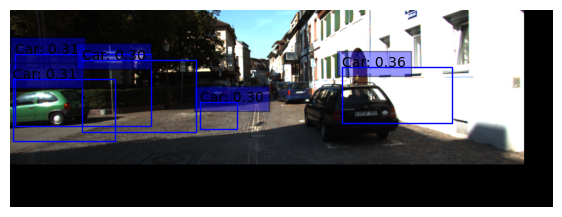

<Axes: >

In [31]:
image, encoded_label, target = val_dataset[15] # (3, H, W)

input_image = image.unsqueeze(0) # (1, 3, H, W)

boxes, scores, classes = run_inference(model, input_image, threshold=0.3)

# 시각화를 위한 이미지 역정규화
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
vis_image = image * std + mean
vis_image = torch.clamp(vis_image, 0, 1)
vis_image = vis_image.permute(1, 2, 0).numpy() # (H, W, 3)
vis_image = (vis_image * 255).astype(np.uint8)

class_names_map = list(train_dataset.class_dict.keys())
pred_class_names = [class_names_map[i] for i in classes]

print(f"Detected {len(boxes)} objects")

visualize_detections(
    vis_image,
    boxes,
    pred_class_names,
    scores,
)

# 프로젝트: 자율주행 보조 시스템 만들기

**프로젝트 제출 루브릭**

| 평가 기준 | 달성 여부 및 설명 |
|-----------|--------------------|
| KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다. | KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다. |
| RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다. | 바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다. |
| 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다. | 테스트 수행결과 90% 이상의 정확도를 보였다. |

In [35]:
best_map_path = os.path.join(save_dir, 'checkpoint_best_map.pth')
if os.path.exists(best_map_path):
    checkpoint = torch.load(best_map_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded Best mAP Model for Inference")
else:
    print("Using current model (Best mAP checkpoint not found)")

model.eval()

def self_drive_assist(img_path, size_limit=300):
    try:
        original_image = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return "Error"

    image_tensor = TF.to_tensor(original_image)
    input_image, new_size, ratio = resize_and_pad_image(image_tensor, training=False)
    ratio = ratio.item()

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    input_image = (input_image - mean) / std

    input_image = input_image.unsqueeze(0).to(device)

    boxes, scores, classes = run_inference(model, input_image, threshold=0.3)

    # Class ID Mapping 
    # 0:Car, 1:Van, 2:Truck, 3:Pedestrian, 4:Person_sitting, 5:Cyclist, 6:Tram, 7:Misc
    person_ids = [3, 4, 5]       # 사람 관련 클래스
    vehicle_ids = [0, 1, 2, 6]   # 차량 관련 클래스

    for box, cls in zip(boxes, classes):
        cls_id = cls.item()

        # 조건 1: 사람이 감지되면 무조건 정지
        if cls_id in person_ids:
            return "Stop"

        # 조건 2: 차량 크기가 300px 이상이면 정지
        if cls_id in vehicle_ids:
            # 박스 좌표는 Resized/Padded 이미지 기준이므로 Original Scale로 변환
            # ratio = new_size / old_size  =>  old_size = new_size / ratio
            x1, y1, x2, y2 = box
            width = (x2 - x1) / ratio
            height = (y2 - y1) / ratio

            if width >= size_limit or height >= size_limit:
                return "Stop"

    return "Go"

Loaded Best mAP Model for Inference


Testing on 10 KITTI validation images...
[1/10] Image: 005984.png -> Decision: Go


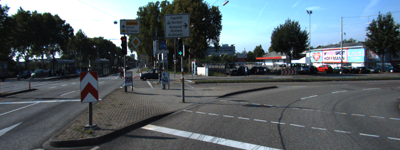

[2/10] Image: 005985.png -> Decision: Go


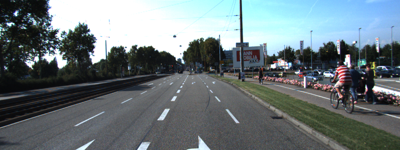

[3/10] Image: 005986.png -> Decision: Stop


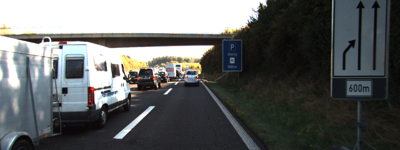

[4/10] Image: 005987.png -> Decision: Go


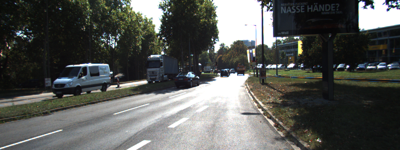

[5/10] Image: 005988.png -> Decision: Stop


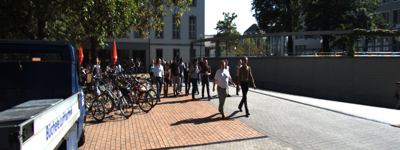

[6/10] Image: 005989.png -> Decision: Go


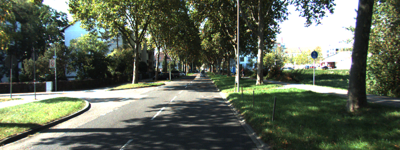

[7/10] Image: 005990.png -> Decision: Stop


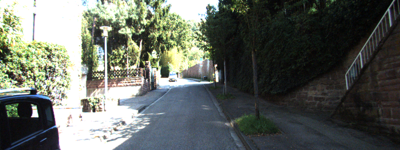

[8/10] Image: 005991.png -> Decision: Go


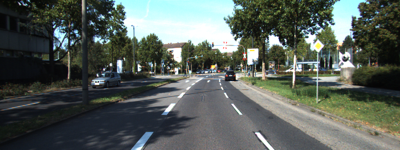

[9/10] Image: 005992.png -> Decision: Stop


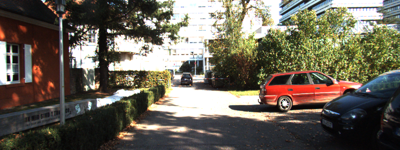

[10/10] Image: 005993.png -> Decision: Go


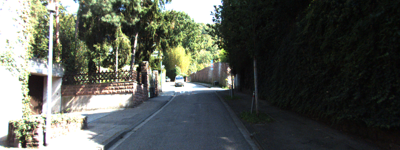

In [34]:
def test_system_with_kitti(func, dataset, num_samples=10):
    print(f"Testing on {num_samples} KITTI validation images...")

    for i in range(num_samples):
        filename = dataset.filenames[i]
        img_path = os.path.join(dataset.img_dir, filename)

        decision = func(img_path)

        print(f"[{i+1}/{num_samples}] Image: {filename} -> Decision: {decision}")


        display(Image.open(img_path).resize((400, 150)))


test_system_with_kitti(self_drive_assist, val_dataset, num_samples=10)